# v3_nst_afx_hyper2.ipynb

Hyperparameter search on the v3_nst_afx model using a genetic algorithm.

This second version optimizes a different set of parameters to those in `v3_nst_afx_hyper`. "Focused" searches can be made on subsets of parameters.

In [1]:
%cd ../..
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from datetime import datetime
from multiprocessing import Pool

/home/z/projects/draculab


In [2]:
%load_ext Cython

In [3]:
%%cython
from draculab import *

In [4]:
%cd notebook/spinal/
from net_from_cfg import *
%cd ../..

/home/z/projects/draculab/notebook/spinal
/home/z/projects/draculab


In [5]:
# A method to mutate individual parameters of a configuration
focus_params = False # whether to focus mutations on a specific set of parameters

# Specify paramters and ranges
# defaults are based on incumbent 9 of smac_pars in v3_normal_smac_test.ipynb
ranges = {"dely_low": {"low": 0.05, "high": 1., "default": 0.65 },
          "dely_diff": {"low": 0.02, "high": 1., "default": 0.94 },
          "sig1": {"low": 0.02, "high": 1., "default":0.5},
          "sig2": {"low": 0.02, "high": 1., "default":0.3},
          "integ_amp": {"low": 0.0, "high": 2., "default":0.24},
          "integ_decay": {"low": 0.5, "high": 2., "default":1.7},
          # tau_slow is important because it controls how long adaptation lasts
          "C_tau_slow": {"low": 4., "high": 50., "default":27.},
          # parameters from modifications to defaults in v3_normal_smac_test
          "SF_slope_factor": {"low": 1., "high": 20., "default":8.},
          "M__C_w_sum": {"low": 0.5, "high": 4., "default":3.},
          "g_e_factor": {"low": 0.5, "high": 4., "default":2.3},
          "SPF_w": {"low": 0.5, "high": 3., "default":1.5},
          "adapt_amp": {"low": 0., "high": 20., "default":5.},
          "b_e": {"low": .5, "high": 10., "default":3.5},
          "AL_thresh": {"low": 0., "high": .8, "default":.3},
          # parameters that came when playing with n3_nst_afxB
          "C__C_antag": {"low": 0., "high": 2., "default":0.7}, 
          "C__C_p_antag": {"low": -0.5, "high": 1., "default":0.1},
          "CE__CI_w": {"low": 0., "high": 2., "default":1.},
          "CI__CE_w": {"low": -.3, "high": -.1, "default":-2.},
          # parameters to find a network without M modulated by SPF
          "M_thresh" : {"low": -.2, "high": 2., "default":.1},
          "M_slope" : {"low": .3, "high": 4., "default":3.},
          "AF__M_de_rate" : {"low": 0., "high": .1, "default":.01},
          "AF__M_dr_amp" : {"low": 0., "high": .1, "default":.01},
          "AF__M_w_sum" : {"low": 1., "high": 50., "default":15.},
          "AF__M_lrate" : {"low": 0.1, "high": 40., "default":10.},
          "M_p1_inp" : {"low": .0, "high": 4., "default":.5},
          "M__C_lrate" : {"low": 1, "high": 30., "default":5.}
         }

#par_list = [name for name in ranges] # ordered list with names of the parameters
par_list = list(ranges.keys())
# parameters to focus on
#main_pars = ["SF_slope_factor", "M__C_w_sum", "g_e_factor", "SPF_w", "b_e", "AL_thresh",
#             "C__C_antag", "C__C_p_antag", "CE__CI_w", "CI__CE_w"]
#main_pars = ["M_thresh", "M_slope", "M__C_lrate", "AF__M_w_sum", "AF__M_lrate", "M_p1_inp"]
# if focus_params == True, ignore the other parameters
if focus_params:
    par_list = main_pars
    
# Altering some ranges to force AF__M participation
ranges['M_p1_inp']['high'] = 1.5
ranges['AF__M_w_sum']['low'] = 5.
ranges['M_thresh']['low'] = .5
ranges['M_thresh']['high'] = 4.

def mutate(cfg, name_list=par_list):
    """ Mutate a single parameter of the given configuration. 
    
        Args:
            name_list: list with names of candidate parameters.
    """
    n = np.random.randint(len(name_list))
    par_name = name_list[n]
    l = ranges[par_name]['low']
    h = ranges[par_name]['high']
    cfg[par_name] =  l + (h-l)*np.random.random()
    
def soft_mutate(cfg, ma, name_list=par_list):
    """ Soft-mutate a single parameter of the given configuration.
    
        A 'soft mutation' keeps the mutated value close to the original value.
        The maximum amplitude of the mutation is given by the 'ma' argument.
        
        Args:
            ma : float in (0,1]. Max. amplitude as fraction of the parameter's range 
            name_list: list with names of candidate parameters.
    """
    n = np.random.randint(len(name_list))
    par_name = name_list[n]
    l = ranges[par_name]['low']
    h = ranges[par_name]['high']
    cfg[par_name] = max(l, min(h, cfg[par_name] + ma * (h-l) * (np.random.random()-0.5)))

In [8]:
# Create the initial population: step 1
# Based on the SMAC incumbents
smac_pop = [
{'C_tau_slow':49.900, 'integ_decay':1.332, 'dely_diff':0.448, 'sig2':0.532, 'dely_low':0.769, 'sig1':0.486, 'M__C_lrate':20.256, 'integ_amp':1.868, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':27.252, 'integ_decay':1.115, 'dely_diff':0.830, 'sig2':0.602, 'dely_low':0.945, 'sig1':0.333, 'M__C_lrate':80.272, 'integ_amp':1.303, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':4.914, 'integ_decay':1.298, 'dely_diff':0.870, 'sig2':0.674, 'dely_low':0.102, 'sig1':0.656, 'M__C_lrate':18.098, 'integ_amp':0.980, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':18.108, 'integ_decay':1.897, 'dely_diff':0.916, 'sig2':0.543, 'dely_low':0.180, 'sig1':0.396, 'M__C_lrate':70.582, 'integ_amp':1.600, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':24.518, 'integ_decay':1.732, 'dely_diff':0.105, 'sig2':0.881, 'dely_low':0.482, 'sig1':0.296, 'M__C_lrate':10.718, 'integ_amp':0.053, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':25.131, 'integ_decay':1.264, 'dely_diff':0.152, 'sig2':0.522, 'dely_low':0.297, 'sig1':0.167, 'M__C_lrate':8.160, 'integ_amp':0.721, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':27.709, 'integ_decay':0.990, 'dely_diff':0.074, 'sig2':0.958, 'dely_low':0.385, 'sig1':0.142, 'M__C_lrate':62.358, 'integ_amp':1.229, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':12.997, 'integ_decay':0.623, 'dely_diff':0.508, 'sig2':0.363, 'dely_low':0.725, 'sig1':0.255, 'M__C_lrate':57.655, 'integ_amp':0.859, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':28.257, 'integ_decay':1.587, 'dely_diff':0.876, 'sig2':0.034, 'dely_low':0.841, 'sig1':0.272, 'M__C_lrate':19.252, 'integ_amp':1.978, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':27.010, 'integ_decay':1.676, 'dely_diff':0.938, 'sig2':0.307, 'dely_low':0.652, 'sig1':0.514, 'M__C_lrate':17.694, 'integ_amp':0.242, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':25.729, 'integ_decay':0.524, 'dely_diff':0.249, 'sig2':0.303, 'dely_low':0.975, 'sig1':0.413, 'M__C_lrate':48.402, 'integ_amp':0.794, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':39.010, 'integ_decay':1.341, 'dely_diff':0.499, 'sig2':0.684, 'dely_low':0.334, 'sig1':0.955, 'M__C_lrate':33.119, 'integ_amp':0.165, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':27.252, 'integ_decay':1.177, 'dely_diff':0.979, 'sig2':0.703, 'dely_low':0.983, 'sig1':0.128, 'M__C_lrate':79.764, 'integ_amp':1.266, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':29.745, 'integ_decay':1.500, 'dely_diff':0.050, 'sig2':0.606, 'dely_low':0.899, 'sig1':0.154, 'M__C_lrate':9.902, 'integ_amp':1.844, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':35.892, 'integ_decay':1.006, 'dely_diff':0.870, 'sig2':0.430, 'dely_low':0.478, 'sig1':0.452, 'M__C_lrate':33.372, 'integ_amp':1.246, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':34.454, 'integ_decay':1.519, 'dely_diff':0.182, 'sig2':0.121, 'dely_low':0.862, 'sig1':0.855, 'M__C_lrate':30.181, 'integ_amp':1.193, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':36.125, 'integ_decay':1.005, 'dely_diff':0.313, 'sig2':0.755, 'dely_low':0.281, 'sig1':0.902, 'M__C_lrate':19.180, 'integ_amp':1.293, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':27.216, 'integ_decay':1.192, 'dely_diff':0.606, 'sig2':0.647, 'dely_low':0.938, 'sig1':0.067, 'M__C_lrate':24.822, 'integ_amp':1.976, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':43.652, 'integ_decay':0.807, 'dely_diff':0.984, 'sig2':0.399, 'dely_low':0.080, 'sig1':0.259, 'M__C_lrate':19.631, 'integ_amp':0.164, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 },
{'C_tau_slow':40.219, 'integ_decay':1.590, 'dely_diff':0.089, 'sig2':0.502, 'dely_low':0.911, 'sig1':0.481, 'M__C_lrate':24.110, 'integ_amp':1.147, 'adapt_amp':5.00, 'SF_slope_factor':8.00, 'g_e_factor':2.00, 'AL_thresh':0.30, 'M__C_w_sum':3.00, 'b_e':4.00, 'SPF_w':1.50 }]


# Load the results from generation 26 in v3_nst_afx_hyper
fname = '/home/z/projects/draculab/saves/v3_nst_afx_pop_2020-08-09__20_39_gen26'
with (open(fname, "rb")) as f:
    gen26_pop = pickle.load(f)
    f.close()

# Load the results from a previous search in v3_nst_afx_hyper2
#fname = 'v3_nst_afx_pop_2020-09-04__09_52_cns2'
fname = '/home/z/projects/draculab/saves/v3_nst_afx_pop_2020-09-15__10_22'
with (open(fname, "rb")) as f:
    cns2_pop1 = pickle.load(f)
    f.close()

fname = '/home/z/projects/draculab/saves/v3_nst_afx_pop_2020-09-19__16_25'
with (open(fname, "rb")) as f:
    cns2_pop2 = pickle.load(f)
    f.close()

    

In [9]:
# Create the initial population: step 2
# option 1: every individual shares the basic elements of gen26_pop[0] or cns2_pop[0]
# Useful for focused search
#pop = [gen26_pop[0].copy() for _ in range(pop_size)]
#pop = [cns2_pop[0].copy() for _ in range(pop_size)]

# option 2: initial population is gen_26_pop with last elements replaced by smac_pop
#pop = gen26_pop[:pop_size-len(smac_pop)] + smac_pop
pop = cns2_pop1[:15] + cns2_pop2[:15] + gen26_pop[:15] + smac_pop[:15]

pop_size = len(pop)

# create variations of the parameters we want to investigtate

# first fill the default values in n_def elements
# n_def = 3
# for ind in range(n_def):
#     for name in main_pars:
#         pop[ind][name] = ranges[name]['default']
        
# # fill the rest with variations in both directions
# chg_name = ["low", "default", "high"] # auxiliary list
# for ind in range(n_def, pop_size):
#     chg_dirs = [chg_name[i] for i in np.random.randint(3, size=len(par_list))]
#     for idx, name in enumerate(par_list):
#         pop[ind][name] = 0.5 * (ranges[name][chg_dirs[idx]] + ranges[name]["default"])
        
# Throw n_muts mutations, and n_soft_muts soft mutations
# n_muts = 20
# n_soft_muts = 10
# perm = np.random.permutation(pop_size)
# for i in range(n_muts):
#     mutate(pop[perm[i]])
# for i in range(n_muts,n_muts+n_soft_muts):
#     soft_mutate(pop[perm[i]], 0.2)

# reset fitness and number of evaluations
for dic in pop:
    dic['fitness'] = None # average fitness value
    dic['n_evals'] = 0  # number of times fitness has been evaluated
    
# Insert parameters that configure the network with desired static values
net_conf = {"M_mod":False,
            "lowpass_SP":False,
            "noisy_syns":False,
            "M__C_decay":False,
            "AF__M_decay":False }
for dic in pop:
    for name in net_conf:
        dic[name] = net_conf[name]
        
# Reset values for parameters with altered ranges
alt_ranges = ['M_p1_inp', 'AF__M_w_sum', 'M_thresh']
chg_name = ["low", "default", "high"] # auxiliary list
for dic in pop:
    chg_dirs = [chg_name[i] for i in np.random.randint(3, size=len(alt_ranges))]
    for idx, name in enumerate(alt_ranges):
        dic[name] = 0.5 * (ranges[name][chg_dirs[idx]] + ranges[name]["default"])
        
# Insert default values for any missing parameters
for name in ranges:
    for cfg in pop:
        if not name in cfg:
            cfg[name] = ranges[name]['default']

In [10]:
# print used configuration
for dic in pop[0:5]:
    print('{',end='')
    for name in dic.keys():
        if name in net_conf:
            print("\'%s\':%s, "%(name, dic[name]), end='')
        if name != 'fitness' or dic['fitness'] != None:
            print("\'%s\':%.2f, " % (name, dic[name]), end='')
    print('}\n')

pop[0]

{'C_tau_slow':23.24, 'integ_decay':1.68, 'dely_diff':0.61, 'sig2':0.65, 'dely_low':0.94, 'sig1':0.07, 'M__C_lrate':3.00, 'integ_amp':1.94, 'adapt_amp':5.00, 'SF_slope_factor':4.50, 'g_e_factor':2.30, 'AL_thresh':0.06, 'M__C_w_sum':1.75, 'b_e':3.50, 'SPF_w':2.25, 'n_evals':0.00, 'C__C_antag':1.65, 'C__C_p_antag':0.55, 'CE__CI_w':0.95, 'CI__CE_w':-2.00, 'M_thresh':2.05, 'M_slope':3.24, 'AF__M_w_sum':32.50, 'AF__M_lrate':25.00, 'M_p1_inp':0.50, 'M_mod':False, 'M_mod':0.00, 'lowpass_SP':False, 'lowpass_SP':0.00, 'noisy_syns':False, 'noisy_syns':0.00, 'M__C_decay':False, 'M__C_decay':0.00, 'AF__M_decay':False, 'AF__M_decay':0.00, 'AF__M_de_rate':0.01, 'AF__M_dr_amp':0.01, }

{'C_tau_slow':23.24, 'integ_decay':1.68, 'dely_diff':0.61, 'sig2':0.65, 'dely_low':0.94, 'sig1':0.07, 'M__C_lrate':3.00, 'integ_amp':1.94, 'adapt_amp':5.00, 'SF_slope_factor':4.50, 'g_e_factor':2.30, 'AL_thresh':0.06, 'M__C_w_sum':1.75, 'b_e':3.50, 'SPF_w':2.25, 'n_evals':0.00, 'C__C_antag':1.65, 'C__C_p_antag':0.55, 'C

{'C_tau_slow': 23.242490852056637,
 'integ_decay': 1.676,
 'dely_diff': 0.606,
 'sig2': 0.647,
 'dely_low': 0.938,
 'sig1': 0.067,
 'M__C_lrate': 3.0,
 'integ_amp': 1.9404408352576688,
 'adapt_amp': 5.0,
 'SF_slope_factor': 4.5,
 'g_e_factor': 2.3,
 'AL_thresh': 0.05624690639116503,
 'M__C_w_sum': 1.75,
 'b_e': 3.5,
 'SPF_w': 2.25,
 'fitness': None,
 'n_evals': 0,
 'C__C_antag': 1.6505660923374748,
 'C__C_p_antag': 0.55,
 'CE__CI_w': 0.9450317641444606,
 'CI__CE_w': -2.0,
 'M_thresh': 2.05,
 'M_slope': 3.238538232297488,
 'AF__M_w_sum': 32.5,
 'AF__M_lrate': 25.0,
 'M_p1_inp': 0.5,
 'M_mod': False,
 'lowpass_SP': False,
 'noisy_syns': False,
 'M__C_decay': False,
 'AF__M_decay': False,
 'AF__M_de_rate': 0.01,
 'AF__M_dr_amp': 0.01}

In [7]:
# Load the results from a previous run
#fname = '/home/z/projects/draculab/saves/v3_nst_afx_pop_2021-05-07__11_51'
fname = '/home/z/projects/draculab/saves/v3_nst_afx_pop_2021-05-10__10_41'
with (open(fname, "rb")) as f:
    pop = pickle.load(f)
    f.close()

# If the results are form a run with fewer parameters
# fill it with the default values.
for cfg in pop:
    for name in ranges:
        if not name in cfg:
            cfg[name] = ranges[name]['default']

In [8]:
# A function to produce offspring by crossing individuals
par_names = list(pop[0].keys()) # list with all parameter names

def create_offspring(cfg1, cfg2, par_list=par_names):
    """ Given 2 configurations, return 2 offspring from random swapping.
    
        To produce offspring, first we choose one split point in the
        dictionary. The first offspring has the values of cfg1 up to that
        point, and cfg2 afterwards. The second offspring has the cfg2 values
        up to the split point, and cfg1 afterwards. Since the dictionaries are
        not ordered, we use a parameter list to set the split point.
    
        Args:
            cfg1, cfg2: parameter dictionaries
            par_list: list with the keys in cfg1, cfg2
        Returns:
            cfg3, cfg4: dictionaries from swapping values in cfg1, cfg2
    """
    if focus_params:
        par_list = main_pars
    sp = np.random.randint(len(par_list))# split point as an index to par_list
    cfg3 = cfg1.copy()
    cfg4 = cfg2.copy()
    for i in range(sp, len(par_list)):
        cfg3[par_list[i]] = cfg2[par_list[i]]
        cfg4[par_list[i]] = cfg1[par_list[i]]
    return cfg3, cfg4

# visualize
# cfg3, cfg4 = create_offspring(pop[10], pop[11])
# for dic in (pop[10], pop[11], cfg3, cfg4):
#     print('{',end='')
#     for name in par_names:
#         if name != "fitness":
#             print("\'%s\':%.2f, " % (name, dic[name]), end='')
#     print('}\n')


In [9]:
# A function that evaluates the fitness of a given configuration
def eval_config(cfg):
    """ Returns the error for a network with a given configuration.

        Args:
            cfg : a configuration dictionary.
        Returns:
            error : A float calculated from the sum of activities in the SPF layer.
    """
    np.random.seed() # will try to get a seed from /dev/urandom
    if cfg['n_evals'] > 8: # if the fitness has been evaluated "enough" times. See cell below...
        return cfg['fitness']
    
    # obtain a network with the given configuration
    (net, pops_dict, hand_coords, m_idxs,
     t_pres, _) = net_from_cfg(cfg,
                     M_mod=cfg['M_mod'] if 'M_mod' in cfg else True,
                     lowpass_SP=cfg['lowpass_SP'] if 'lowpass_SP' in cfg else False,
                     noisy_syns=cfg['noisy_syns'] if 'noisy_syns' in cfg else False,
                     M__C_decay=cfg['M__C_decay'] if 'M__C_decay' in cfg else False,
                     AF__M_decay=cfg['AF__M_decay'] if 'AF__M_decay' in cfg else False)
    # run the network
    run_time = 800.
    #start_time = time.time()
    times, data, plant_data  = net.flat_run(run_time)
    #print('Execution time is %s seconds' % (time.time() - start_time))

    # calculate average error in last ~300 seconds of reaching
    P = pops_dict['P']
    arm_activs = plant_data[P]
    plant = net.plants[P]
    # modified copy-paste of plt.upd_ip_impl
    q1 = arm_activs[:,0]
    q2 = arm_activs[:,2]
    q12 = q1+q2
    c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
    c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                    c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
    coord_idxs = np.floor(times/t_pres).astype(int)
    des_coords = np.array(hand_coords)[m_idxs[coord_idxs],:] # desired coordinates at each moment in time

    error_time = run_time - round(run_time/3.)
    error_idx = int(round(error_time/net.min_delay))
    hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
    hand_error_integ = hand_error[error_idx:].sum()
    avg_hand_error = hand_error_integ / (hand_error.size - error_idx)

    #return hand_error_integ
    return avg_hand_error

In [10]:
####################################
###### The genetic algorithm ######
####################################

# pop = pop[0:6] # limit pop size for debugging
n_mates = 15 # number of individuals to mate at each generation (even number)
max_gens = 30 #10 # maximum number of generations
n_soft_mut = 5 # numbef of individuals to soft-mutate per generation
r_soft_mut = 0.2 # relative amplitude of soft mutations
n_mut = 6 # number of individuals to mutate per generation
n_procs = 30 # number of processes to use for fitness evaluation
n_save = 3 # number of individuals to protect from replacement and mutation
# setting name for file where parameters will be stored
fname = "v3_nst_afx_pop"
fname += "_" + datetime.now().strftime('%Y-%m-%d__%H_%M')

for gen in range(max_gens):
    start_time = time.time()
    # 1) Evaluate fitness
    # 1.1) Do the evaluation
    ######### Single process version
    #fits = list(map(eval_config, pop))
    ######## parallel version
    with Pool(n_procs) as p:
        fits = list(p.map(eval_config, pop))
        p.close()
        p.join()
    #print(fits)
    # 1.2) update the average fitness values
    for idx, cfg in enumerate(pop):
        nr = cfg['n_evals'] # n_evals is not updated yet...
        #print(nr)
        #print(fits[idx])
        #print(cfg['fitness'])
        if nr > 0:
            if nr < 9: # horrible arbitrary number that might be different in eval_config :( 
                cfg['fitness'] = (cfg['fitness']*nr + fits[idx])/(nr+1)
        else:
            cfg['fitness'] = fits[idx]
        cfg['n_evals'] = cfg['n_evals'] + 1
    # 2) Sort according to fitness. Lowest error first.
    pop = sorted(pop, key=lambda d: d['fitness'])
    # 2.1) Save current generation
    with open(fname, 'wb') as f:
        pickle.dump(pop, f)
        f.close()
    # 2.2) A quick message
    print("Generation %d evaluated. Best fitness: %.3f"%(gen,pop[0]['fitness']))
    print("Mean fitness = %.3f"%(np.mean(np.array(fits))))
    # 2.3) If best fitness good enough, break
    if pop[0]['fitness'] < 0.02:
        print("Good enough parameters found. Stopping search.")
        break
    # 3) mate and replace
    # 3.1) Select individuals to be replaced with probability proportional to error
    fits.sort() # sort the fitnesses (now in the same order as pop)
    fits = np.array(fits)
    fits = fits/fits.sum() # normalize fitnesses so they add to 1
    cumsum_fits = fits[:] # cumsum_fits[i] = sum(fits[:i])
    for i in range(1,len(cumsum_fits)):
        cumsum_fits[i] = cumsum_fits[i-1] + cumsum_fits[i]
    repl_list = [] # list with indexes of individuals to be replaced
    while len(repl_list) < n_mates:
        min_r = cumsum_fits[n_save] # don't replace the first n_save individuals
        r = min_r + (1.-min_r) * np.random.random()
        candidate = n_save
        for i in range(n_save, len(fits)):
            if cumsum_fits[i] > r:
                break
            candidate += 1
        if candidate in repl_list:
            continue
        else:
            repl_list.append(candidate)
    print("to replace: ", end='')
    print(repl_list)
    # 3.2) Arrange individuals in random pairs
    perm = np.random.permutation(n_mates) # this will do 
    # 3.3) mate
    new_pops = []
    for i in range(int(np.floor(n_mates/2))):
        off1, off2 = create_offspring(pop[perm[2*i]], pop[perm[2*i+1]])
        new_pops.append(off1)
        new_pops.append(off2)
    # 3.4) replace
    for i, cfg in enumerate(new_pops):
        pop[repl_list[i]] = cfg
    # 4) mutate
    # 4.1) soft mutations
    for _ in range(n_soft_mut):
        idx = np.random.randint(len(pop))
        if idx < n_save:
            copy = pop[idx].copy()
            soft_mutate(copy, r_soft_mut)
            pop[-idx-1] = copy
            pop[-idx-1]['fitness'] = None
            pop[-idx-1]['n_evals'] = 0
        else:
            soft_mutate(pop[idx], r_soft_mut)
            pop[idx]['fitness'] = None
            pop[idx]['n_evals'] = 0
    # 4.2) mutations
    # 4.2.1) select individuals to mutate
    # sq_fits = fits*fits
    #cumsum_sq_fits = fits * fits # cumsum_sq_fits[i] = sum(sq_fits[:i])
    cumsum_sq_fits = fits # proportional to fits, rather than its square
    cumsum_sq_fits = cumsum_sq_fits / cumsum_sq_fits.sum()
    for i in range(1,len(cumsum_sq_fits)):
        cumsum_sq_fits[i] = cumsum_sq_fits[i-1] + cumsum_sq_fits[i]
    mut_list = [] # list with indexes of individuals to be mutate
    while len(mut_list) < n_mut:
        r = np.random.random()
        candidate = 0
        for i in range(len(fits)):
            if cumsum_sq_fits[i] > r:
                break
            candidate += 1
        if candidate in mut_list:
            continue
        else:
            mut_list.append(candidate)
    print("to mutate: ", end='')
    print(mut_list)
    for idx in mut_list:
        if idx < n_save:
            copy = pop[idx].copy()
            mutate(copy)
            pop[-idx-1] = copy
            pop[-idx-1]['fitness'] = None
            pop[-idx-1]['n_evals'] = 0
        else:
            mutate(pop[idx])
            pop[idx]['fitness'] = None
            pop[idx]['n_evals'] = 0
            
    print('generation %d finished in %s seconds' % (gen, time.time() - start_time))
#     while len(mut_list) < n_mut:
#         min_r = cumsum_sq_fits[n_save] # don't mutate the first n_save individuals
#         r = min_r + (1.-min_r) * np.random.random()
#         candidate = n_save
#         for i in range(n_save, len(fits)):
#             if cumsum_sq_fits[i] > r:
#                 break
#             candidate += 1
#         if candidate in mut_list:
#             continue
#         else:
#             mut_list.append(candidate)
#     print("to mutate: ", end='')
#     print(mut_list)
#     for _ in range(n_mut):
#         idx = np.random.randint(len(pop))
#         mutate(pop[idx])
#         pop[idx]['fitness'] = None
#         pop[idx]['n_evals'] = 0
    

Generation 0 evaluated. Best fitness: 0.126
Mean fitness = 0.171
to replace: [52, 7, 43, 19, 49, 34, 10, 40, 12, 37, 38, 47, 13, 53, 59]
to mutate: [38, 40, 44, 51, 48, 28]
generation 0 finished in 6035.470015764236 seconds
Generation 1 evaluated. Best fitness: 0.126
Mean fitness = 0.161
to replace: [53, 38, 21, 43, 57, 42, 28, 30, 39, 36, 49, 47, 7, 6, 26]
to mutate: [39, 57, 52, 51, 29, 45]
generation 1 finished in 6272.522541284561 seconds
Generation 2 evaluated. Best fitness: 0.125
Mean fitness = 0.155
to replace: [40, 19, 47, 23, 49, 12, 51, 38, 45, 52, 57, 22, 34, 5, 13]
to mutate: [6, 58, 56, 52, 31, 47]
generation 2 finished in 6564.888322353363 seconds
Generation 3 evaluated. Best fitness: 0.129
Mean fitness = 0.165
to replace: [8, 11, 55, 21, 51, 40, 4, 20, 56, 23, 26, 14, 48, 15, 59]
to mutate: [57, 58, 54, 33, 47, 13]
generation 3 finished in 6922.427759647369 seconds
Generation 4 evaluated. Best fitness: 0.102
Mean fitness = 0.157
to replace: [54, 34, 9, 56, 35, 31, 25, 5,

In [11]:
# print final population
for dic in pop[:5]:
    print('{',end='')
    for name in dic.keys():
        if name != 'fitness' or dic['fitness'] != None:
            print("\'%s\':%.2f, " % (name, dic[name]), end='')
    print('}\n')

pop[0]

{'C_tau_slow':23.24, 'integ_decay':1.68, 'dely_diff':0.61, 'sig2':0.65, 'dely_low':0.94, 'sig1':0.33, 'M__C_lrate':3.00, 'integ_amp':2.00, 'adapt_amp':5.57, 'SF_slope_factor':8.36, 'g_e_factor':1.16, 'AL_thresh':0.06, 'M__C_w_sum':1.75, 'b_e':3.01, 'SPF_w':2.25, 'fitness':0.12, 'n_evals':35.00, 'C__C_antag':1.65, 'C__C_p_antag':0.55, 'CE__CI_w':1.89, 'CI__CE_w':-2.00, 'M_thresh':0.97, 'M_slope':1.65, 'AF__M_w_sum':7.59, 'AF__M_lrate':26.43, 'M_p1_inp':1.00, 'M_mod':0.00, 'lowpass_SP':0.00, 'noisy_syns':0.00, 'M__C_decay':0.00, 'AF__M_decay':0.00, 'AF__M_de_rate':0.06, 'AF__M_dr_amp':0.01, }

{'C_tau_slow':23.24, 'integ_decay':1.68, 'dely_diff':0.61, 'sig2':0.65, 'dely_low':0.94, 'sig1':0.33, 'M__C_lrate':3.00, 'integ_amp':2.00, 'adapt_amp':5.57, 'SF_slope_factor':8.36, 'g_e_factor':1.16, 'AL_thresh':0.06, 'M__C_w_sum':1.75, 'b_e':3.01, 'SPF_w':2.25, 'fitness':0.12, 'n_evals':35.00, 'C__C_antag':1.65, 'C__C_p_antag':0.55, 'CE__CI_w':1.89, 'CI__CE_w':-2.00, 'M_thresh':0.97, 'M_slope':1.6

{'C_tau_slow': 23.242490852056637,
 'integ_decay': 1.676,
 'dely_diff': 0.606,
 'sig2': 0.647,
 'dely_low': 0.938,
 'sig1': 0.3286318234484798,
 'M__C_lrate': 3.0,
 'integ_amp': 2.0,
 'adapt_amp': 5.573673053045277,
 'SF_slope_factor': 8.35915489292676,
 'g_e_factor': 1.1645170980353663,
 'AL_thresh': 0.05624690639116503,
 'M__C_w_sum': 1.75,
 'b_e': 3.0075343697733357,
 'SPF_w': 2.25,
 'fitness': 0.1154230098812345,
 'n_evals': 35,
 'C__C_antag': 1.6505660923374748,
 'C__C_p_antag': 0.55,
 'CE__CI_w': 1.8858412087560117,
 'CI__CE_w': -2.0,
 'M_thresh': 0.9739338927394239,
 'M_slope': 1.65,
 'AF__M_w_sum': 7.591771212520483,
 'AF__M_lrate': 26.42567570616394,
 'M_p1_inp': 1.0,
 'M_mod': False,
 'lowpass_SP': False,
 'noisy_syns': False,
 'M__C_decay': False,
 'AF__M_decay': False,
 'AF__M_de_rate': 0.05809214387956866,
 'AF__M_dr_amp': 0.01}

In [12]:
# print final population
for dic in pop[:5]:
    print('{',end='')
    for name in dic.keys():
        if name != 'fitness' or dic['fitness'] != None:
            print("\'%s\':%.2f, " % (name, dic[name]), end='')
    print('}\n')

pop[0]

{'C_tau_slow':23.24, 'integ_decay':1.68, 'dely_diff':0.61, 'sig2':0.65, 'dely_low':0.94, 'sig1':0.07, 'M__C_lrate':3.00, 'integ_amp':1.94, 'adapt_amp':5.57, 'SF_slope_factor':8.36, 'g_e_factor':1.16, 'AL_thresh':0.06, 'M__C_w_sum':1.75, 'b_e':3.01, 'SPF_w':2.25, 'fitness':0.06, 'n_evals':1.00, 'C__C_antag':1.65, 'C__C_p_antag':0.55, 'CE__CI_w':0.95, 'CI__CE_w':-2.00, 'M_thresh':1.05, 'M_slope':3.24, 'AF__M_w_sum':1.00, 'AF__M_lrate':26.50, 'M_p1_inp':2.20, 'M_mod':0.00, 'lowpass_SP':0.00, 'noisy_syns':0.00, 'M__C_decay':0.00, 'AF__M_decay':0.00, 'AF__M_de_rate':0.01, 'AF__M_dr_amp':0.01, }

{'C_tau_slow':23.24, 'integ_decay':1.68, 'dely_diff':0.61, 'sig2':0.65, 'dely_low':0.94, 'sig1':0.07, 'M__C_lrate':3.00, 'integ_amp':1.94, 'adapt_amp':5.57, 'SF_slope_factor':4.50, 'g_e_factor':2.30, 'AL_thresh':0.06, 'M__C_w_sum':1.75, 'b_e':3.01, 'SPF_w':2.25, 'fitness':0.09, 'n_evals':25.00, 'C__C_antag':1.65, 'C__C_p_antag':0.55, 'CE__CI_w':0.95, 'CI__CE_w':-2.00, 'M_thresh':1.05, 'M_slope':3.24

{'C_tau_slow': 23.242490852056637,
 'integ_decay': 1.676,
 'dely_diff': 0.606,
 'sig2': 0.647,
 'dely_low': 0.938,
 'sig1': 0.067,
 'M__C_lrate': 3.0,
 'integ_amp': 1.9404408352576688,
 'adapt_amp': 5.573673053045277,
 'SF_slope_factor': 8.35915489292676,
 'g_e_factor': 1.1645170980353663,
 'AL_thresh': 0.05624690639116503,
 'M__C_w_sum': 1.75,
 'b_e': 3.0075343697733357,
 'SPF_w': 2.25,
 'fitness': 0.05510764087823033,
 'n_evals': 1,
 'C__C_antag': 1.6505660923374748,
 'C__C_p_antag': 0.55,
 'CE__CI_w': 0.9450317641444606,
 'CI__CE_w': -2.0,
 'M_thresh': 1.05,
 'M_slope': 3.238538232297488,
 'AF__M_w_sum': 1.0,
 'AF__M_lrate': 26.497927730877652,
 'M_p1_inp': 2.1991838355412754,
 'M_mod': False,
 'lowpass_SP': False,
 'noisy_syns': False,
 'M__C_decay': False,
 'AF__M_decay': False,
 'AF__M_de_rate': 0.01,
 'AF__M_dr_amp': 0.01}

In [ ]:
# Save the final population
fname = "v3_nst_afx_pop"
fname += "_" + datetime.now().strftime('%Y-%m-%d__%H_%M')
with open(fname, 'wb') as f:
    pickle.dump(pop, f)
    f.close()

In [ ]:
# Load a saved population
import pickle
fname = 'v3_nst_afx_pop'
with (open(fname, "rb")) as f:
    results = pickle.load(f)
    f.close()

In [10]:
# Test a configuation
cfg_id = 0 # index in the population for the configuration
net, pops_dict, hand_coords, m_idxs, t_pres, _  = net_from_cfg(pop[cfg_id])
pops_names = ['SF', 'SP', 'SPF', 'AL', 'AF', 'SP_CHG', 'CE', 'CI', 'M', 'ACT', 'P']
for name in pops_names:
    exec("%s = %s"% (name, str(pops_dict[name])))

start_time = time.time()
times, data, plant_data  = net.flat_run(600.)
#times, data, plant_data  = net.run(40.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)
#Execution time is 8.687349319458008 seconds  << before sc_inp_sum_mp, flat_run(5.)

Execution time is 1527.3152508735657 seconds


Same history as `v3_nst_afx`
...


[5.05124599e-031 2.27301228e-019 5.26801864e-001 4.88097116e-001
 9.38724727e-323 2.04113160e-001 6.69556780e-018 2.43985163e-001
 4.44390515e-100 3.48279568e-001 9.38724727e-323 5.57241680e-001]
[1.51261849e-031 5.71185226e-020 3.14551881e-001 2.66709089e-001
 5.43472210e-323 2.15785961e-002 2.94195368e-018 3.28142410e-002
 1.93533840e-100 1.32517824e-001 5.92878775e-323 1.64592415e-001]


NameError: name 'M_CE_track' is not defined

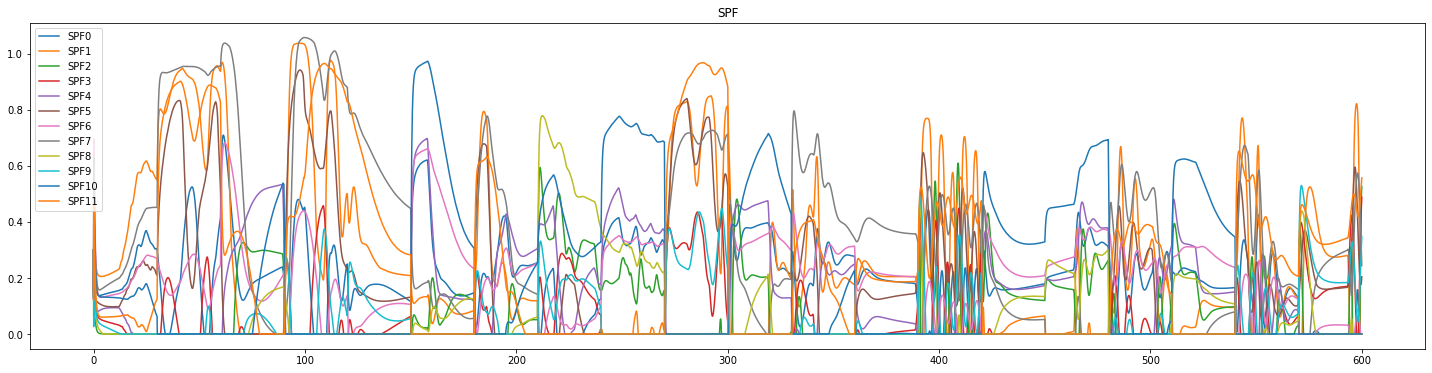

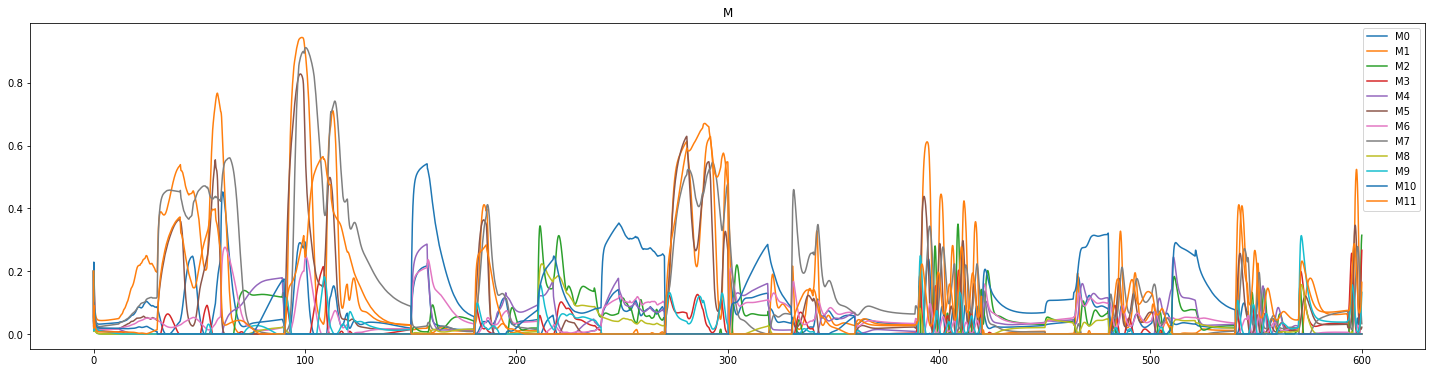

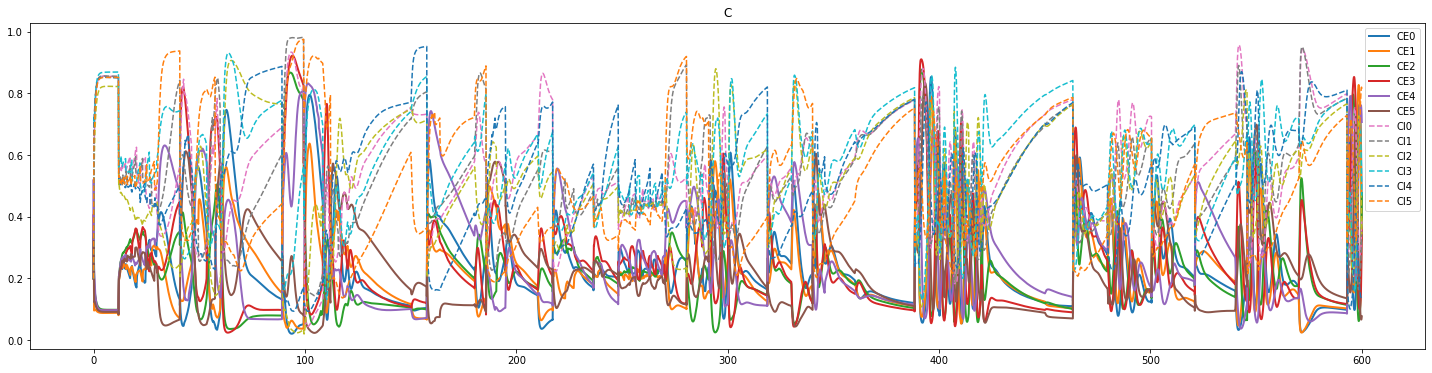

<Figure size 1800x432 with 0 Axes>

In [11]:
arm_activs = plant_data[P]
# SPF
fs = (25,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends)
plt.title('SPF')
print(SPF_data[:,-1])

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends)
plt.title('M')
print(M_data[:,-1])

# C
C_fig = plt.figure(figsize=fs)
CE_data = np.array(data[CE])
CI_data = np.array(data[CI])
plt.plot(times, CE_data.transpose(), linewidth=2)
plt.plot(times, CI_data.transpose(), '--')
C_legends = ['CE'+str(i) for i in range(len(CE))]
C_legends += ['CI'+str(i) for i in range(len(CI))]
plt.legend(C_legends)
plt.title('C')

# M--CE0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_CE_track])
plt.plot(times, w_track_data.transpose())
M_CE0_legends = ['M'+str(i)+'--CE0' for i in range(len(M_CE_track))]
plt.legend(M_CE0_legends)
plt.title('M--CE0 weights')

# AF--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[AF_M0_track[0:18]])
plt.plot(times, w_track_data2.transpose())
AF_M0_legends = ['AF'+str(i)+'--M0' for i in range(len(AF_M0_track[:18]))]
plt.legend(AF_M0_legends)
plt.title('AF--M0 weights exc')
"""
W_fig3 = plt.figure(figsize=fs)
w_track_data3 = np.array(data[AF_M0_track[18:]])
plt.plot(times, w_track_data3.transpose())
AF_M0_legends2 = ['AF'+str(i)+'--M0' for i in range(len(AF_M0_track[18:]))]
plt.legend(AF_M0_legends2)
plt.title('AF--M0 weights inh')
"""

plt.show()

shoulder angle: 0.166651, shoulder vel: 1.364184
AFe_data:
[3.50658283e-01 3.66402199e-01 3.02356819e-01 2.13655701e-01
 4.86713216e-01 1.36245115e-01 2.80419585e-02 2.59519944e-22
 1.97044578e-01 7.20611454e-02 1.00703924e-01 1.20309217e-02
 2.00545193e-01 1.29488096e-01 2.16393549e-01 1.97739244e-01
 2.03343265e-01 1.27330966e-01]
AFi_data:
[1.83746253e-47 8.08282321e-65 2.12373619e-03 1.05954640e-01
 1.48554884e-56 1.85680259e-01 2.78813641e-01 3.63962009e-01
 1.24164001e-01 2.43164773e-01 2.18372893e-01 2.91097592e-01
 1.20384907e-01 1.92068986e-01 1.02925700e-01 1.23416285e-01
 1.17344666e-01 1.94091168e-01]


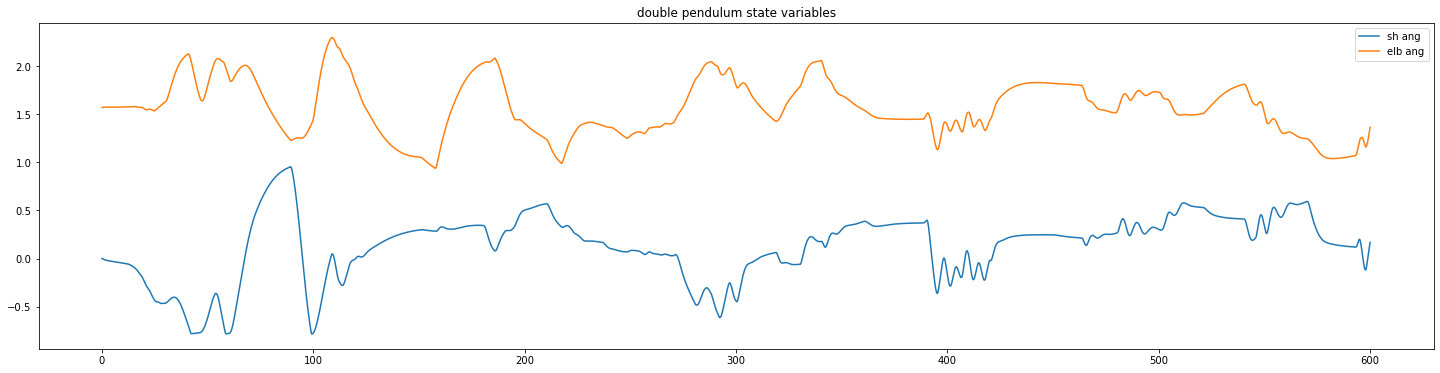

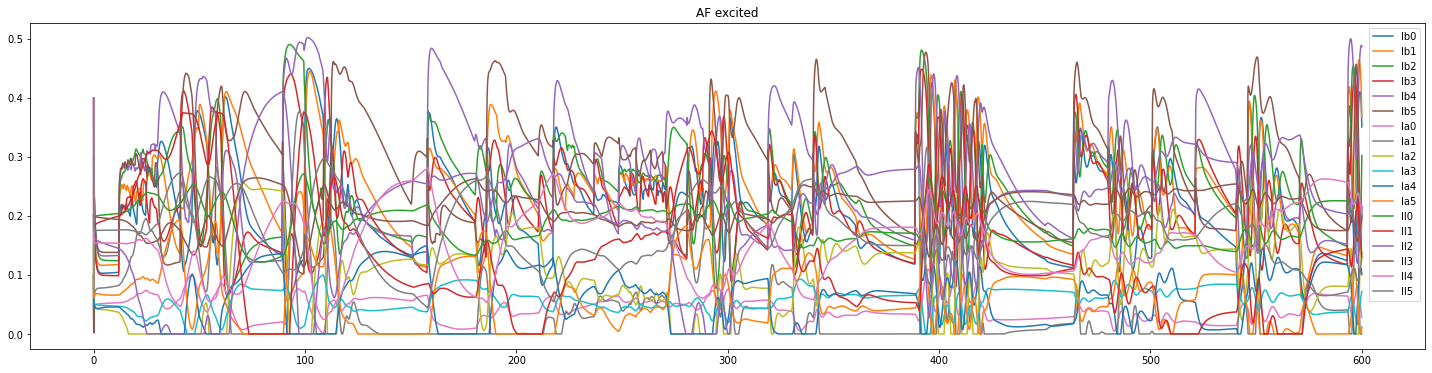

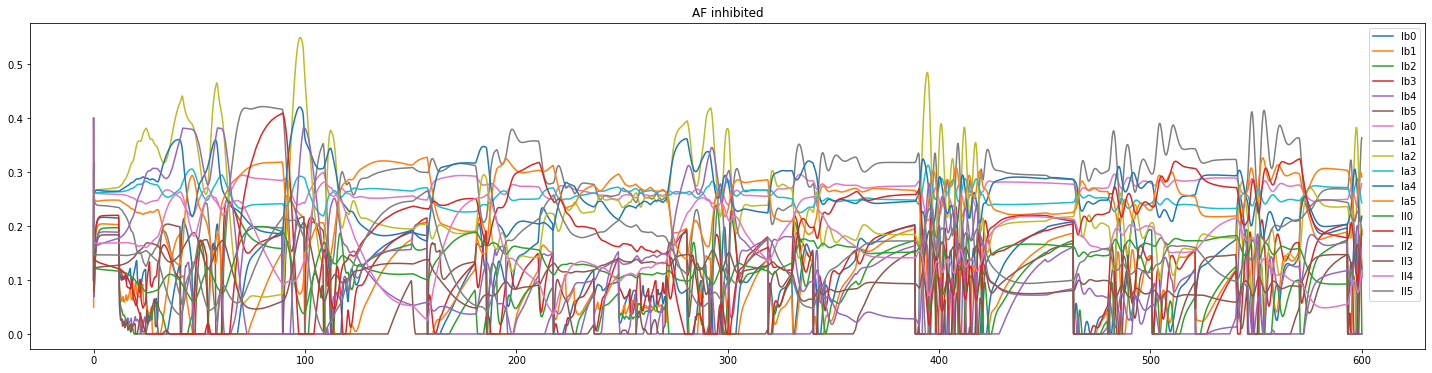

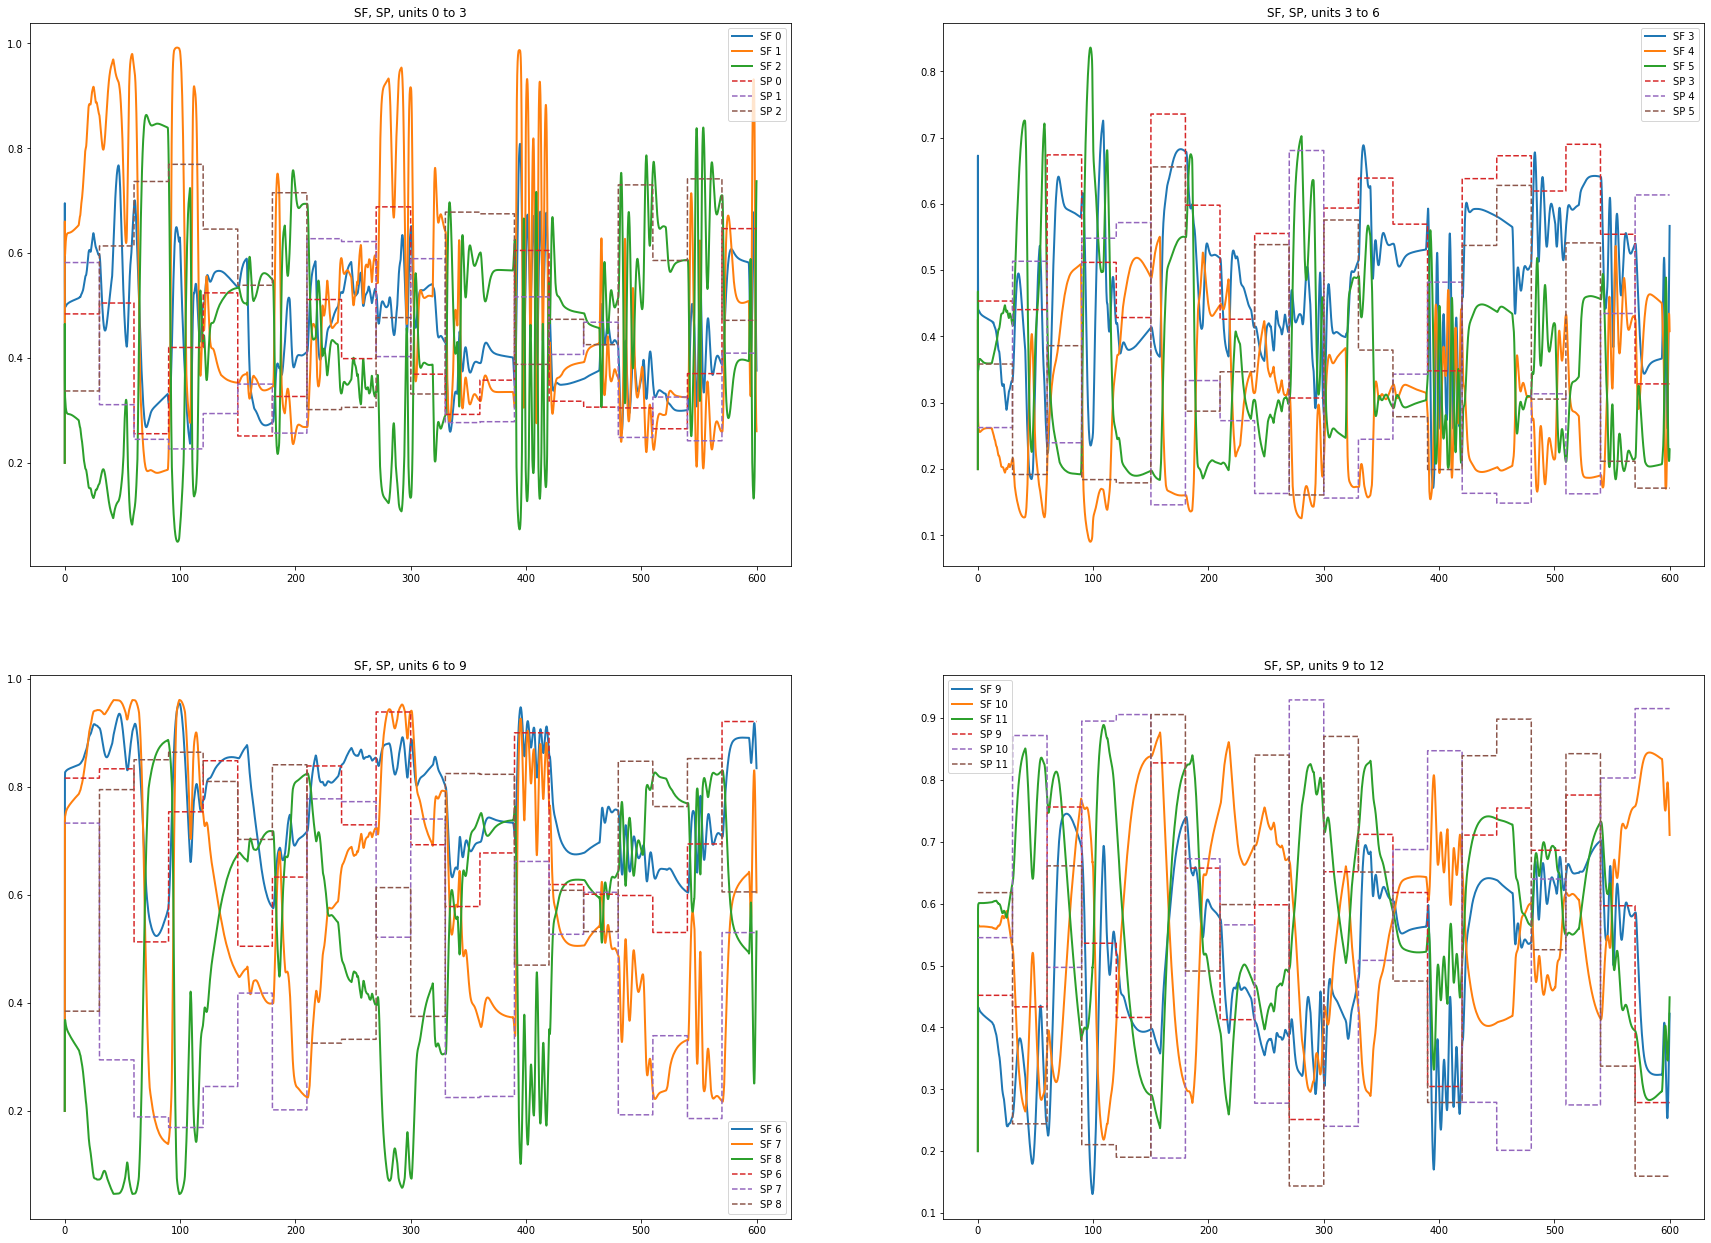

SF = 
[0.37596412 0.26030551 0.73737472 0.56669555 0.40798681 0.22984632
 0.83481807 0.60483617 0.5324081  0.42212935 0.71107971 0.44869723]
SP = 
[0.64683017 0.409279   0.47191472 0.32848431 0.61343353 0.17132093
 0.9212691  0.53035578 0.60572591 0.27844306 0.91538568 0.15944595]


In [12]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4:2]
plt.plot(times, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

# AF plus
AFe_fig = plt.figure(figsize=fs)
AFe_data = np.array(data[AF[0:18]])
plt.plot(times, AFe_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF excited')
print('AFe_data:')
print(AFe_data[:,-1])

# AF minus
AFi_fig = plt.figure(figsize=fs)
AFi_data = np.array(data[AF[18:36]])
plt.plot(times, AFi_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF inhibited')
print('AFi_data:')
print(AFi_data[:,-1])

fs = (30,10)
# SF, SP
SF_fig, axs = plt.subplots(2, 2, figsize=(fs[0], 2.2*fs[1]))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
for row in range(2):
    for col in range(2):
        ax = axs[row][col]
        base = 3*col + 6*row
        ax.plot(times, SF_data[base:base+3, :].transpose(), linewidth=2)
        ax.plot(times, SP_data[base:base+3, :].transpose(), '--')
        ax.set_title('SF, SP, units %d to %d' % (base, base+3))
        SF_legends = ['SF '+ str(base+i) for i in range(3)]
        SP_legends = ['SP '+ str(base+i) for i in range(3)]
        ax.legend(SF_legends + SP_legends)

plt.show()
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

average error: 0.155351


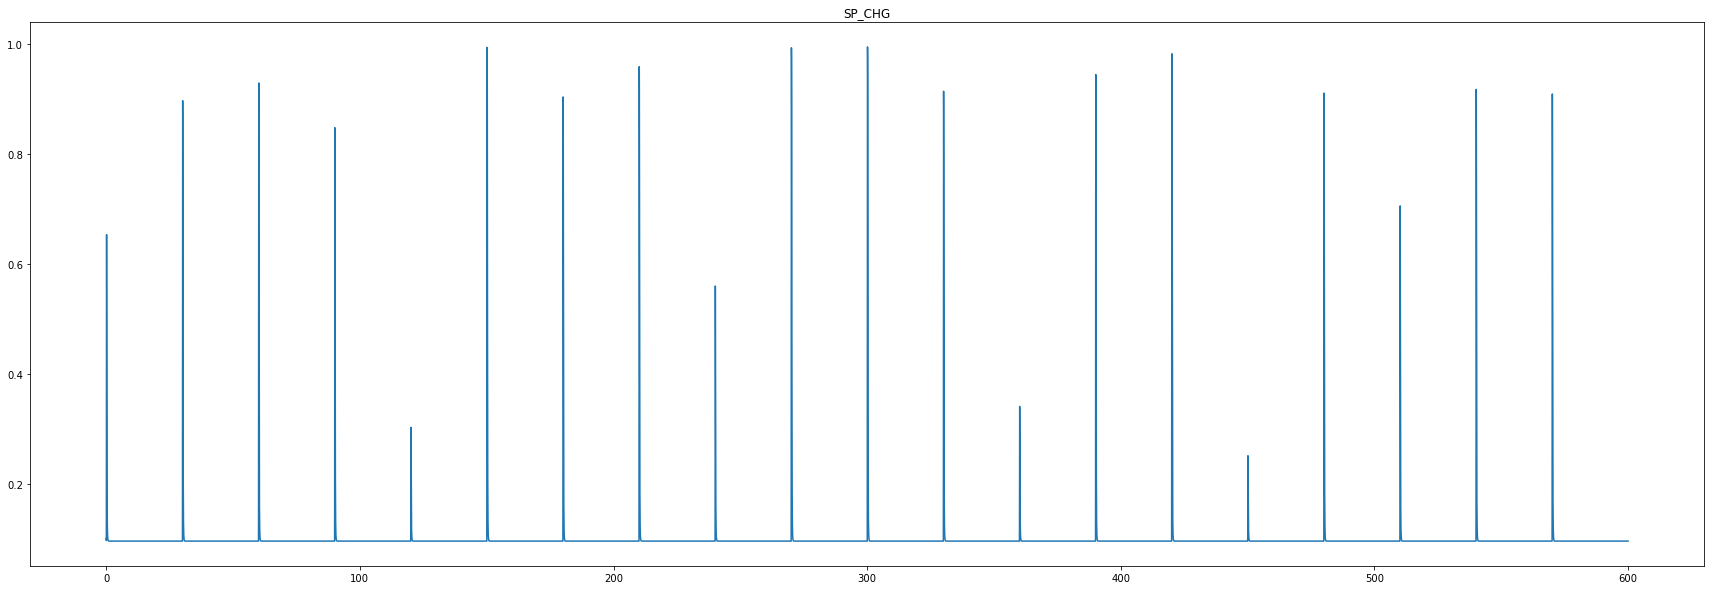

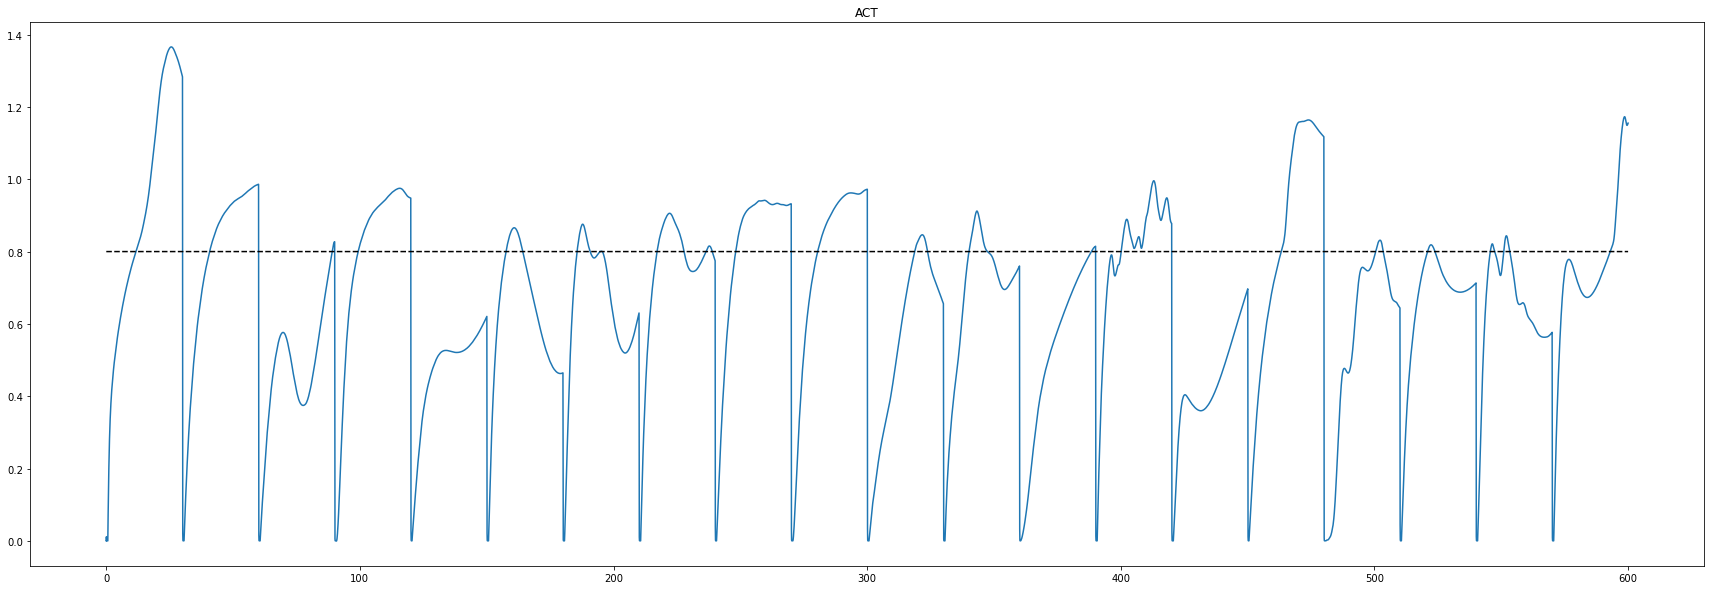

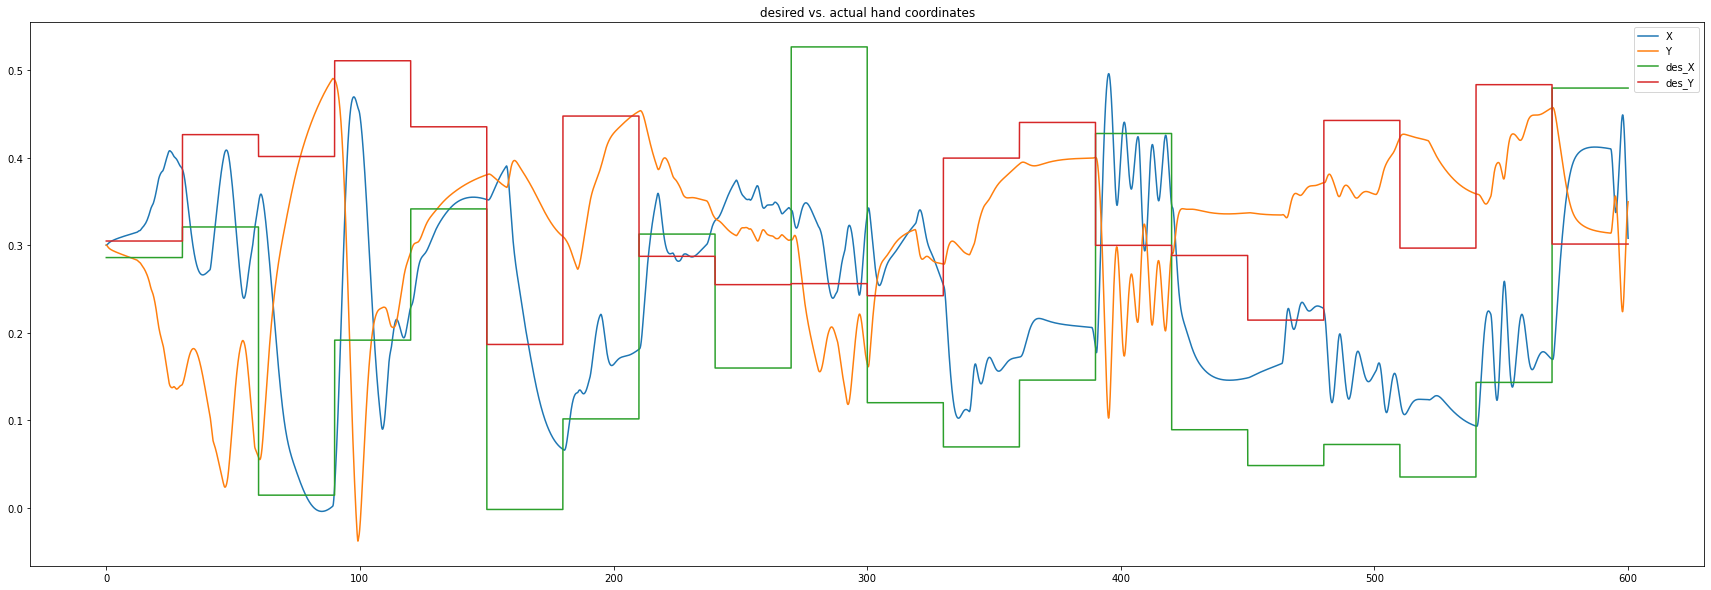

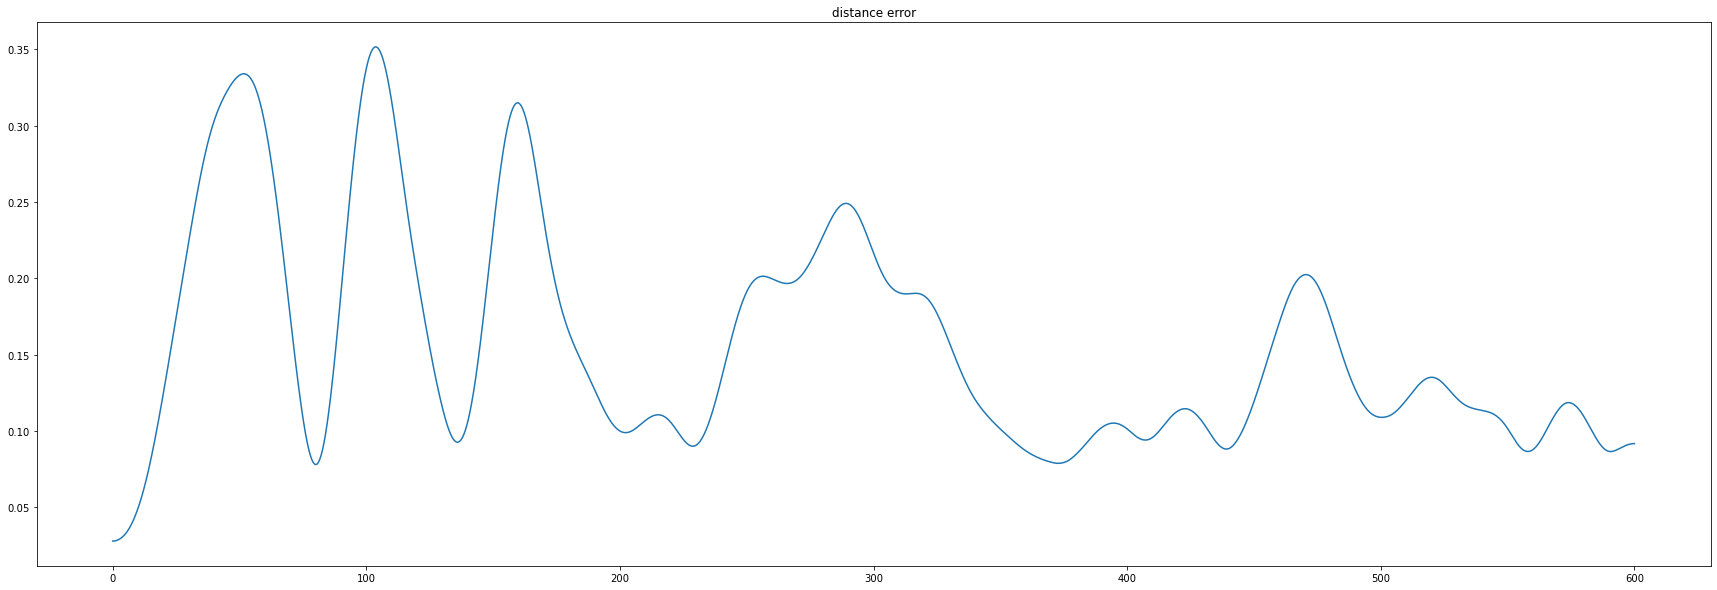

In [13]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

chg_fig = plt.figure(figsize=fs)
chg_data = np.array(data[SP_CHG])[0]
plt.plot(times, chg_data)
plt.title('SP_CHG')

act_fig = plt.figure(figsize=fs)
act_data = np.array(data[ACT])[0]
plt.plot(times, act_data)
plt.plot(times, 0.8*np.ones_like(times), 'k--')
plt.title('ACT')

plant = net.plants[P]
# modified copy-paste of plt.upd_ip_impl
q1 = arm_activs[:,0]
q2 = arm_activs[:,2]
q12 = q1+q2
c_elbow = np.array((plant.l_arm*np.cos(q1), plant.l_arm*np.sin(q1)))
c_hand = np.array((c_elbow[0] + plant.l_farm*np.cos(q12),
                   c_elbow[1] + plant.l_farm*np.sin(q12))).transpose()
coord_idxs = np.floor(times/t_pres).astype(int)
des_coords = np.array(hand_coords)[m_idxs[coord_idxs],:] # desired coordinates at each moment in time
coords_fig = plt.figure(figsize=fs)
plt.plot(times, c_hand)
plt.plot(times, des_coords)
plt.title('desired vs. actual hand coordinates')
plt.legend(['X', 'Y', 'des_X', 'des_Y'])

err_fig = plt.figure(figsize=fs)
w_len = 8001
hand_error = np.linalg.norm(c_hand-des_coords, axis=1)
smooth_hand_error = smooth(hand_error, window_len=w_len)[int(np.floor(w_len/2)):-int(np.floor(w_len/2))]
plt.plot(times, smooth_hand_error)
plt.title('distance error')
avg_error = hand_error.sum()/hand_error.size
print("average error: %f" % (avg_error))

plt.show()

In [14]:
# plot all factors in the MX--C0 synaptic plasticity

print('X=%d' % (X))
#fs = (30,8)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_now_data = np.array(data[sp_now_track[0]])
sp_del_data = np.array(data[sp_del_track[0]])
spj_now_data = np.array(data[spj_now_track[0]])
spj_del_data = np.array(data[spj_del_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_now_data)
plt.plot(times, sp_del_data)
plt.plot(times, spj_now_data)
plt.plot(times, spj_del_data)
plt.legend(['xp', 'up', 'sp_now', 'sp_del', 'spj_now', 'spj_del'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
C2 = f1 * (sp_now_data - spj_now_data)
C1 = f1 * (sp_del_data - spj_del_data)
rule = 200. * (C2 - C1)
plt.plot(times, f1)
plt.plot(times, 100*C1)
plt.plot(times, 100*C2)
plt.plot(times, rule, linewidth=5)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'C1', 'C2', 'prod'])

plt.show()

NameError: name 'X' is not defined

AL_data:
[0.49009709 0.46438513 0.52067346 0.40189894 0.73724599 0.16862436]
Ib avg for muscle 0= 0.29228753667183466
Ia avg for muscle 0= 0.09329641213801025
II avg for muscle 0= 0.2543145294430991
Ib avg for muscle 1= 0.3208050166178814
Ia avg for muscle 1= 0.08259260672970528
II avg for muscle 1= 0.19497382460119253
Ib avg for muscle 2= 0.33098926064293743
Ia avg for muscle 2= 0.1383230153972166
II avg for muscle 2= 0.2780532492031009
Ib avg for muscle 3= 0.2906931139093501
Ia avg for muscle 3= 0.10871189705429213
II avg for muscle 3= 0.28535660624608633
Ib avg for muscle 4= 0.3675252558597445
Ia avg for muscle 4= 0.10392010417488508
II avg for muscle 4= 0.22040426234515545
Ib avg for muscle 5= 0.3705587300464649
Ia avg for muscle 5= 0.11172555348545826
II avg for muscle 5= 0.2398169362579748


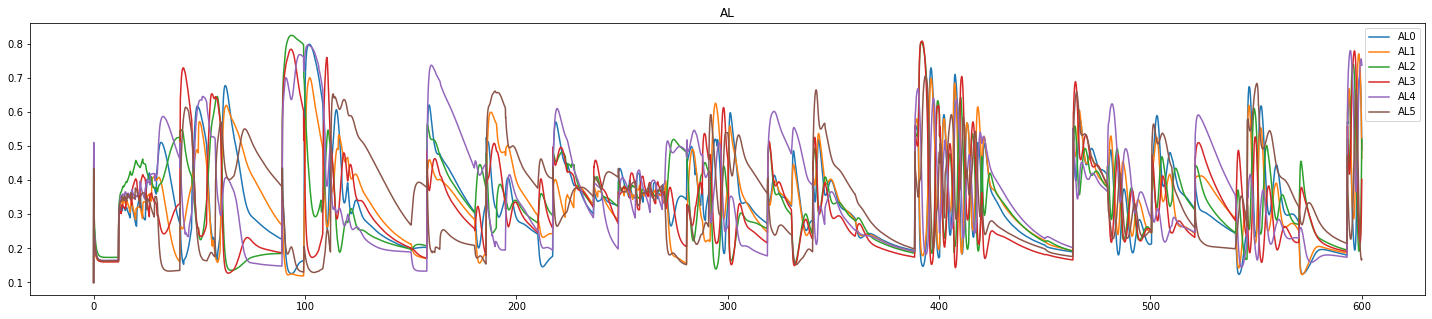

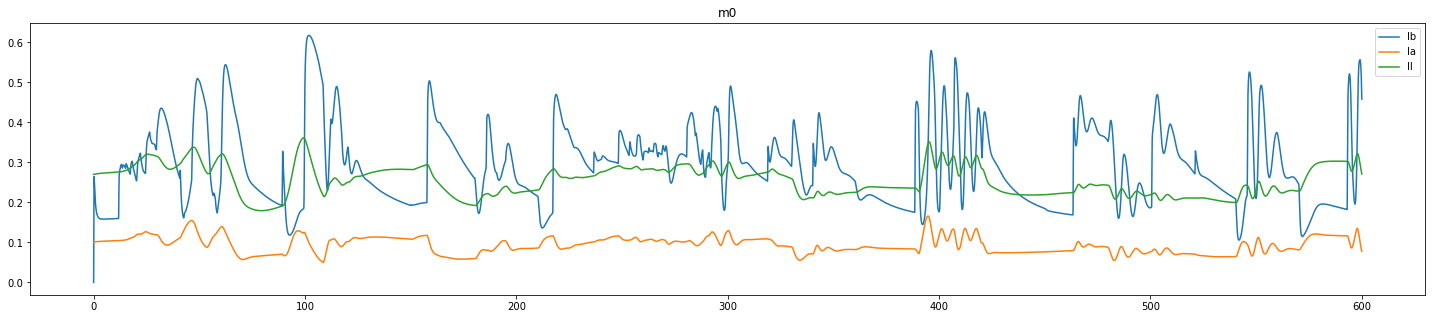

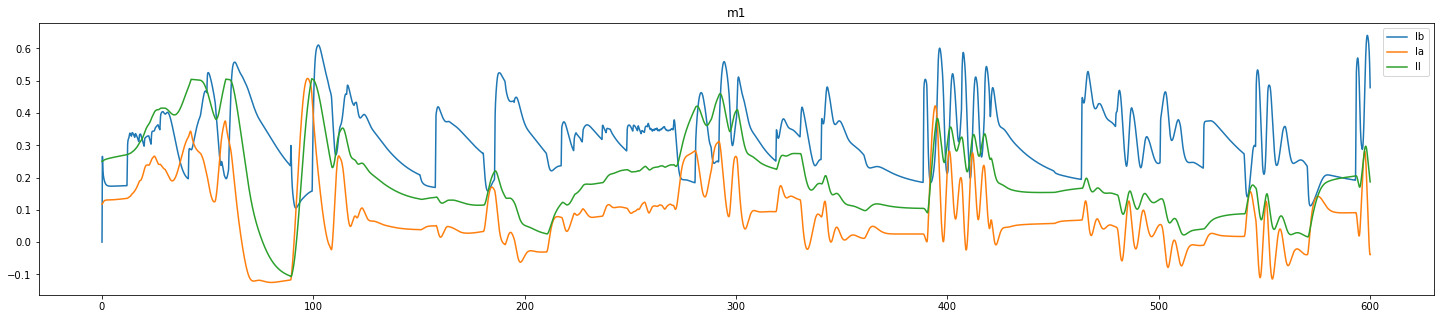

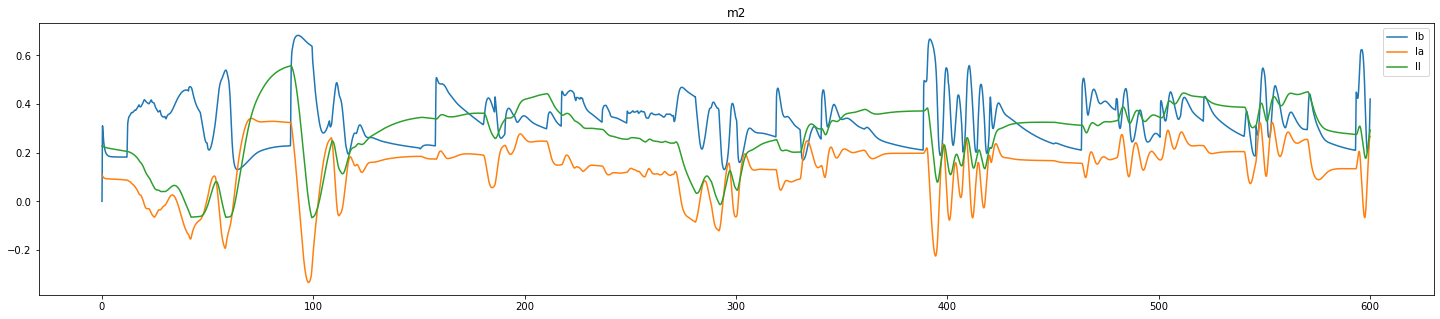

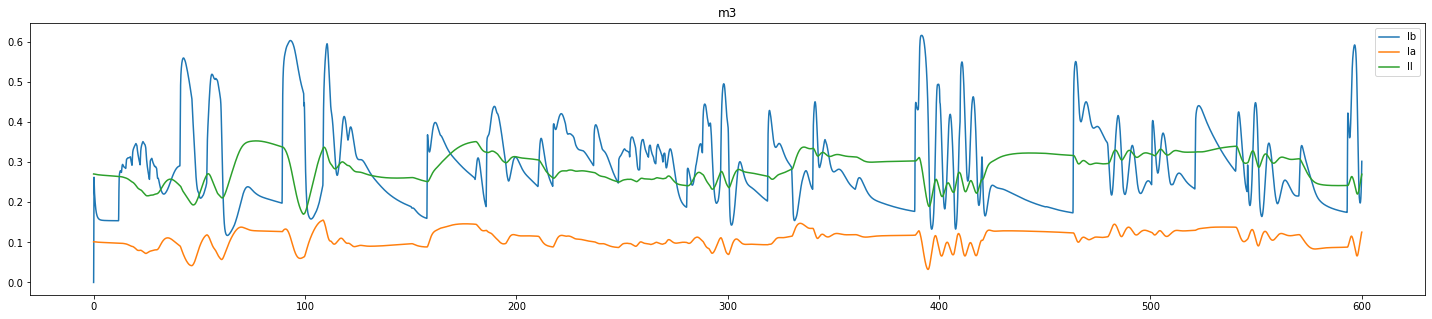

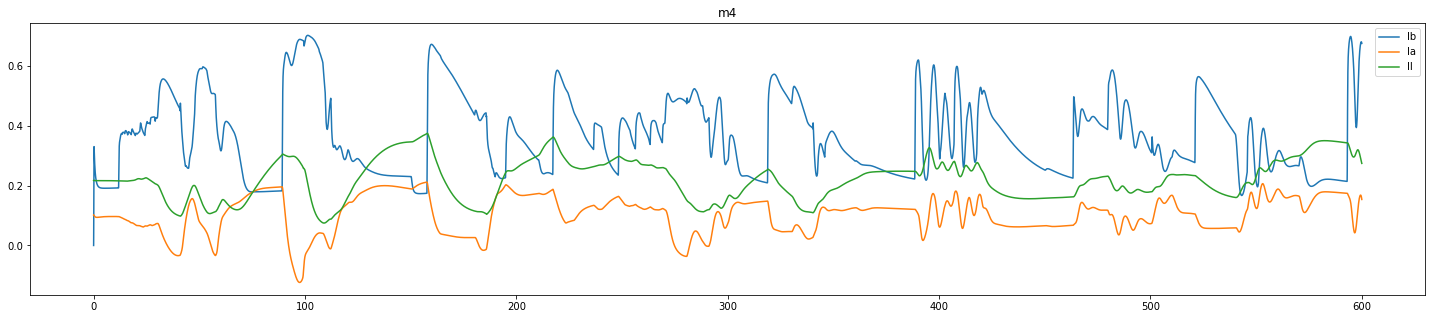

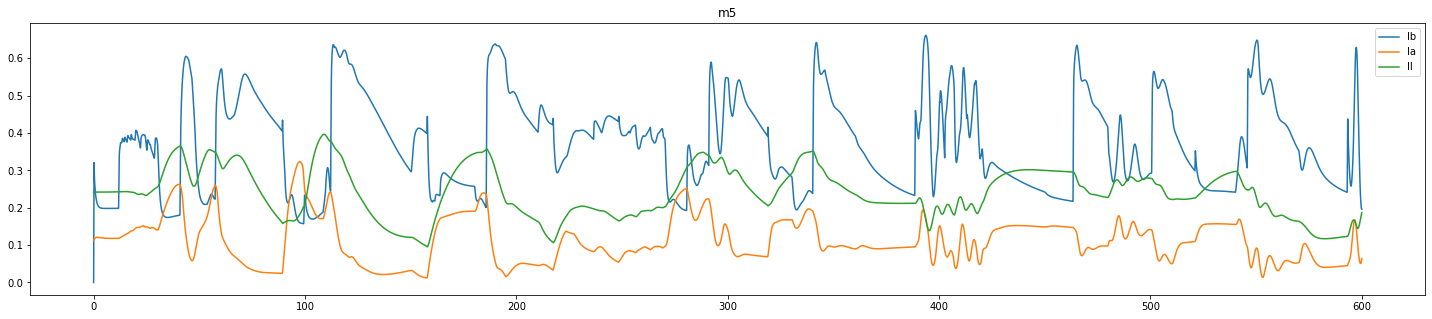

In [15]:
# Alpha units
fs2 =(25,5)
AL_fig = plt.figure(figsize=fs2)
AL_data = np.array(data[AL])
plt.plot(times, AL_data.transpose())
AL_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(AL_legends)
plt.title('AL')
print('AL_data:')
print(AL_data[:,-1])

# plotting muscle outputs
#fs = (20,5)
legs = ['Ib', 'Ia', 'II']

for i in range(6):
    next_fig = plt.figure(figsize=fs2)
    Ib = arm_activs[:,22+i]
    Ia = arm_activs[:,28+i]
    II = arm_activs[:,34+i]
    plt.plot(times, Ib, times, Ia, times, II)
    #plt.plot(times, Ib)
    plt.legend(legs)
    plt.title('m' + str(i))
    print('Ib avg for muscle '+ str(i) + '= ' + str(np.mean(Ib)))
    print('Ia avg for muscle '+ str(i) + '= ' + str(np.mean(Ia)))
    print('II avg for muscle '+ str(i) + '= ' + str(np.mean(II)))
plt.show()

In [ ]:
# ANALYSIS OF CORRELATIONS BETWEEN ARM AFFERENTS

# obtaining arm afferents and their derivatives
PAF = arm_activs[:10000, 22:40]
PAF_diff = np.gradient(PAF, axis=0) / net.min_delay
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(PAF)
axs[0].set_title('arm afferents')
axs[1].plot(PAF_diff)
axs[1].set_title('derivatives for arm afferents')
axs[1].plot(np.zeros(PAF_diff.shape[0]), 'k')

# comparing some signals
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(PAF[:,6], 'b', PAF[:,14], 'r')
axs[1].plot(PAF[:,6], 'b', PAF[:,10], 'r')

# plotting the correlation of one signal against all others
corr_fig, corr_axs = plt.subplots(6, 3, figsize=(20,30))
for col in range(3):
    for row in range(6):
        #corr = np.correlate(PAF_diff[:,6], PAF_diff[:, 6*col+row], mode='same')
        corr = np.correlate(PAF[:,6], PAF[:, 6*col+row], mode='same')
        corr_axs[row,col].plot(corr)
        corr_axs[row,col].set_ylim([0,280])
        corr_axs[row,col].set_title('PAF ' + str(6*col+row))
plt.show()

In [ ]:
# ANALYSIS OF CORRELATIONS BETWEEN AFFERENT UNITS 
##############################
### NON-NORMALIZED VERSION ###
##############################
# obtaining arm afferents and their derivatives
AFD = data[AF,:20000].transpose()
AFD_diff = np.gradient(AFD, axis=0) / net.min_delay
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(AFD)
axs[0].set_title('arm afferents')
axs[1].plot(AFD_diff)
axs[1].set_title('derivatives for arm afferents')
axs[1].plot(np.zeros(AFD_diff.shape[0]), 'k')

# comparing some signals
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(AFD[:,6], 'b', AFD[:,14], 'r')
axs[1].plot(AFD_diff[:,6], 'b', AFD_diff[:,14], 'r')

# plotting the correlation of one signal against all others
AF__M0_w = [syn.w for syn in net.syns[M[0]] if syn.preID in AF]
corr_fig, corr_axs = plt.subplots(6, 3, figsize=(20,30))
base_idx = 6 # index for positive Ia afferent for muscle 0
mid = int(round(AFD.shape[0]/2.)) # middle index for the signal (where 0 is)
span = min(2000, mid)   # span to plot for the correlation
t = np.linspace(-span*net.min_delay, span*net.min_delay, 2*span)
max_c = 4
min_c = -4
des_val_idx = mid + AF__M_syn['extra_steps']
for col in range(3):
    for row in range(6):
        cur_idx = 6*col+row
        if cur_idx == base_idx: lw = 4
        else: lw = 1
        corr = np.correlate(AFD_diff[:,base_idx], AFD[:,cur_idx], mode='same') # what M0 should be obtaining?
        corr_axs[row,col].plot(t, corr[mid-span:mid+span], linewidth=lw)
        corr_axs[row,col].set_ylim([min_c,max_c])
        corr_axs[row,col].plot(t, 1.*AF__M0_w[cur_idx]*np.ones(len(t)), linewidth=3)
        corr_axs[row,col].plot(t, corr[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        x = t[int(len(t)/2)+AF__M_syn['extra_steps']]
        corr_axs[row,col].plot([x, x], [min_c, max_c], 'g--', linewidth=1)
        corr_axs[row,col].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        corr_axs[row,col].set_title('AF ' + str(cur_idx))
plt.show()

In [ ]:
# plotting AF_diff VS AF_diff instead of AF_diff VS AF, to see if 
# the correlations are more informative
corr_fig2, corr_axs2 = plt.subplots(6, 3, figsize=(20,30))
#max_c = .6
#min_c = -.6
hspan = int(round(span/2.))
hlen = int(round(len(AFD_diff[:,0])))
AFD_diff_red = AFD_diff[hlen-hspan:hlen+hspan, :]
for col in range(3):
    for row in range(6):
        cur_idx = 6*col+row
        if cur_idx == base_idx: lw = 4
        else: lw = 1
        corr = np.correlate(AFD_diff[:,base_idx], AFD_diff_red[:,cur_idx], mode='valid')
        corr_axs2[row,col].plot(t, corr[mid-span:mid+span], linewidth=lw)
        #corr_axs2[row,col].set_ylim([min_c,max_c])
        #corr_axs2[row,col].plot(t, 1.*AF__M0_w[cur_idx]*np.ones(len(t)), linewidth=3)
        corr_axs2[row,col].plot(t, corr[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        x = t[int(len(t)/2)+AF__M_syn['extra_steps']]
        #corr_axs2[row,col].plot([x, x], [min_c, max_c], 'g--', linewidth=1)
        corr_axs2[row,col].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        corr_axs2[row,col].set_title('AF ' + str(cur_idx))
plt.show()

In [ ]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


In [ ]:
len(data[M[0]])

## How to interpret the plots below
**For the first two plot grids**:  
The value at `t=0` is the that comes from using the current `custom_inp_del(2)` values in the rga_diff rule.
Negative `t` values correspond to delay in the M signal, which is what makes most sense in the physical implementation. The value at `t=-x` can be interpreted as the direction of change that the rga_diff learning rule would imply if both `custom_inp_del` and `custom_inp_del2` were increased by `x` time units.


**For the third plot grid**:  
The value at `t=0` is the value of the M-C correlation when C is delayed by `custom_inp_del2`. Values to the left imply increasing the delay in C.

In [ ]:
# ANALYSIS OF CORRELATIONS BETWEEN MOTOR UNITS AND C UNITS
# Modified for the rga_diff rule

# obtaining M,C unit activities and their derivatives
full_size = len(data[M[0]])
D_size = 100000 # number of points we will take from the data signals
corr_size = 1000 # number of points in the correlation vector
MD = data[M, -D_size:].transpose() # take the data from the latest points
w_l = 31 # window length for smoothing
for idx in range(len(M)): # smoothing MD
    MD[:,idx] = smooth(MD[:,idx], window_len=w_l)[int(np.floor(w_l/2)):-int(np.floor(w_l/2))]
MD_diff = np.gradient(MD, axis=0) / net.min_delay
MD_diff_roll = np.roll(MD_diff, -CE_params['custom_inp_del']+CE_params['custom_inp_del2'], axis=0) # advancing MD_diff
# Obtaining means over 2 seconds
mean_win = int(2./net_params['min_delay']) # number of points in the window to extract the means
MD_diff_means = np.zeros_like(MD_diff)
MD_diff_roll_means = np.zeros_like(MD_diff_roll)
for idx in range(mean_win,len(MD_diff[:,0])-1):
        MD_diff_means[idx,:] = np.sum(MD_diff_roll[idx-mean_win:idx,:], axis=0)/mean_win
        MD_diff_roll_means[idx,:] = np.sum(MD_diff_roll[idx-mean_win:idx,:], axis=0)/mean_win
MD_diff_center = MD_diff_means - MD_diff # The NEGATIVE of the centered derivative
MD_diff_roll_center = MD_diff_roll - MD_diff_roll_means
MD_diff_center_red = MD_diff_center[:-corr_size,:]
MD_diff_roll_center_red = MD_diff_roll_center[:-corr_size,:] # when it's second in np.correlate

CD = data[CE+CI, -D_size:].transpose()
CD_diff = np.gradient(CD, axis=0) / net.min_delay
CD_diff_roll = np.roll(CD_diff, CE_params['custom_inp_del2'], axis=0)
CD_diff_roll_means = np.zeros_like(CD_diff_roll)
for idx in range(6):
    CD_diff_roll_means[:, idx] = np.mean(np.delete(CD_diff_roll[:,0:6], idx, axis=1), axis=1)
for idx in range(6,12):
    CD_diff_roll_means[:, idx] = np.mean(np.delete(CD_diff_roll[:,6:12], idx-6, axis=1), axis=1)
CD_diff_roll_center = CD_diff_roll - CD_diff_roll_means
#CD_diff_roll_center_red = CD_diff_roll_center[:-corr_size,:]
hlf_cspan = int(round(corr_size/2.))
CD_diff_roll_center_red = CD_diff_roll_center[hlf_cspan:-hlf_cspan,:]

# plots for the signals used in this the analysis
plt_len=4000  # number of points to plot
fig, axs = plt.subplots(3, 1, figsize=(30, 28))
axs[0].plot(MD[0:plt_len,0])
axs[0].set_title('motor unit activities')

axs[1].plot(MD_diff_center[0:plt_len,0])
axs[1].plot(MD_diff_roll_center[0:plt_len,0])
axs[1].plot(np.zeros(plt_len), 'k')
axs[1].set_title('centered derivatives for motor unit activities')
#axs[1].plot(np.zeros(MD_diff_center.shape[0]), 'k')
axs[1].set_ylim([-.1, .1])

axs[2].plot(CD_diff_roll_center[0:plt_len,0])
axs[2].plot(np.zeros(plt_len), 'k')
#axs[2].set_ylim([-2., 2.])
axs[2].set_title('centered derivatives for C units')
#axs[2].plot(np.zeros(CD_diff_center.shape[0]), 'k')

# plotting the expected weights for pairs of M and CE/CI signals
M__CE_w = [[syn.w for syn in net.syns[c] if syn.preID in M] for c in CE]
corr_figE, corr_axsE = plt.subplots(12, 6, figsize=(40,50))

M__CI_w = [[syn.w for syn in net.syns[c] if syn.preID in M] for c in CI]
corr_figI, corr_axsI = plt.subplots(12, 6, figsize=(40,50))

# plotting the differential correlations for pairs of M and CE/CI signals
corr_figX, corr_axsX = plt.subplots(6, 6, figsize=(40,20))

base_idx = 0 # index for positive Ia afferent for muscle 0
plt_span = min(300, corr_size)   # span to plot for the correlation
#t = np.linspace(-plt_span*net.min_delay, plt_span*net.min_delay, 2*plt_span)
                
hlf_pspn = int(round(plt_span/2.))
t = np.linspace(-hlf_pspn*net.min_delay, hlf_pspn*net.min_delay, plt_span)
#pos_t = np.linspace(0., plt_span*net.min_delay, plt_span)
#neg_t = np.linspace(-(plt_span+1)*net.min_delay, -net.min_delay, plt_span)
#all_t = np.concatenate((neg_t,pos_t))
eqs = np.zeros((12,12)) # matrix indicating whether weight and correlation have same sign
corr_w = np.zeros((12,12)) # what the weight should be, according to the correlation
des_val_idx = hlf_cspan # index in the correlation vector where the weight should be...
                        # depends on CD_diff_diff_roll_center_red was reduced

for col in range(12):  # ranges through C units
    if col < 6:
        axes = corr_axsE
        weights = M__CE_w
        color='b'
    else:
        axes = corr_axsI
        weights = M__CI_w
        color='r'
    mcol = col%6
    for row in range(12):  # ranges through M units
        cur_idx = 12*mcol+row
        if cur_idx == base_idx: lw = 4
        else: lw = 1
        # This corresponds to what should be learned with two different single delays
        # In 'corr' MD is not delayed, and CD is delayed by dely2 (CE_params[custom_inp_del2])
        corr = np.correlate(MD_diff_center[:,row], CD_diff_roll_center_red[:,col], mode='valid')
        #corr = np.correlate(CD_diff_roll_center[:,col], MD_diff_center[:,row], mode='valid')
        # In corr MD is additionally delayed by dely2-dely1
        corr2 = np.correlate(MD_diff_roll_center[:,row], CD_diff_roll_center_red[:,col], mode='valid')
        # this corresponds to what should be learned using the "diff" learning rule
        corr_diff = corr - corr2
        
        # plot value of rga_diff learning rule
        axes[row,mcol].plot(t, corr_diff[hlf_cspan-hlf_pspn:hlf_cspan+hlf_pspn], linewidth=lw, color=color)
        
        corr_w[row,col] = corr_diff[des_val_idx]
        acw = abs(corr_w[row,col])
        t_des = t[hlf_pspn]
        axes[row,mcol].plot(t, max(min(10.*weights[mcol][row],acw),-acw)*np.ones(len(t)), linewidth=3)
        axes[row,mcol].plot(t, corr_diff[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        axes[row,mcol].plot([t_des, t_des], [-corr_w[row,col], corr_w[row,col]], 'g--', linewidth=1)
        axes[row,mcol].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        axes[row,mcol].set_title('M' + str(row) + ', C' + str(col))
        
        if col<6 and row<6:  # plot differential correlation
            # Legacy code:
            #---------------------------------------
            # These are further values of corr when CD rather than MD is further delayed
            # Because the first array is shorter, the arguments will be reversed (see np.convolve documentation);
            # however, the sign of the indexes is not inverted. This means:
            # correlate(MD_diff_center_red,CD_diff_roll_center) == correlate(CD_diff_roll_center,MD_diff_center_red)[::-1]
            #rev_corr = np.correlate(MD_diff_center_red[:,row], CD_diff_roll_center[:,col], mode='valid')
            #corr_axsX[row,col].plot(all_t, np.concatenate((rev_corr[-plt_span:],corr[0:plt_span])), linewidth=3, color='b')
            #---------------------------------------
            corr_axsX[row,col].plot(t, corr[hlf_cspan-hlf_pspn:hlf_cspan+hlf_pspn], linewidth=3, color='b')
            corr_axsX[row,mcol].set_title('M' + str(row) + ', C' + str(col))
            corr_axsX[row,mcol].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
            c0 = abs(corr[des_val_idx])
            corr_axsX[row,mcol].plot([t_des, t_des], [-c0, c0], 'g--', linewidth=1)
        
        # Finding if weights are following the correlations
        scat_s = 50
        scat_c = 'r'
        if np.sign(weights[mcol][row]) == np.sign(corr_diff[des_val_idx]):
            eqs[row,col] = 1.
            scat_s = 90
            scat_c = 'g'
        axes[row,mcol].scatter([t_des], [corr_diff[des_val_idx]], s=scat_s, c=scat_c)
plt.show()

# Regarding whether correlations and weights have the same sign
print(eqs)
print(np.sum(eqs, axis=0))
print(np.sum(eqs, axis=1))
print(sum(eqs.flatten())/(eqs.shape[0]*eqs.shape[1]))
# Regarding desired weights according to correlations
# normalizing columns of corr_w (weights on the same C unit)
n_corr_w = corr_w / np.linalg.norm(corr_w, axis=0)
import re
print('normalized M__CE correlation weight matrix:')
print(re.sub('\[,', '[', re.sub('\ +', ', ', str(n_corr_w[:,:6]))))
print('normalized M__CI correlation weight matrix:')
print(re.sub('\[,', '[', re.sub('\ +', ', ', str(n_corr_w[:,6:]))))

In [ ]:
# Doing a nice print of the AF__M weights in order to initialize them
AF__M_w = np.zeros((len(M), len(AF)))
for idx, mid in enumerate(M):
    AF__M_w[idx, :] = np.array([syn.w for syn in net.syns[mid] if syn.preID in AF])
      
import re

stryn = re.sub('\[,', '[', re.sub('\ +', ', ', str(AF__M_w)))
for c,s in enumerate(re.split(', ', stryn)):
    print(s, end=',')
    if (c+1)%36 == 0: print('\n')


In [ ]:
# checking some connections
print("Connections to motor units")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[AF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to spinal units")
for idx, syn in enumerate(net.syns[CE[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CE, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

for idx, syn in enumerate(net.syns[CI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CI, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")


print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in AL:
        pre_pop = 'AL'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
print("-------------------------\n")

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

In [ ]:
arm_activs.shape

---

In [ ]:
#Animation of the arm and muscles
%matplotlib widget
from numpy import cos, sin
from matplotlib.animation import FuncAnimation
start_time = 0.
start_idx = int(start_time/net.min_delay)

# angles of shoulder and elbow
theta_s = arm_activs[start_idx:,0]
theta_e = arm_activs[start_idx:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
#acts = np.array(data[1])
ipx = data[ipx_track,start_idx:]
ipy = data[ipy_track,start_idx:]
ten = arm_activs[start_idx:, np.array(range(4,10))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2
# creating the figure and axis
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.grid()
# creating lines and points
line, = ax.plot([], [], 'o-b', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
# preparing a colormap for the tensions
ten_max = max(ten.max(), 1e-5)
ten_min = min(ten.min(), -1e-5)
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
#strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs
strt_idx = int(np.round((times[0]+start_time)/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = (frame+start_idx)*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    cur_idx = int(cur_time/t_pres) + strt_idx
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    
    return line, points, mus_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 20), init_func=init, blit=True, interval=20)

plt.show()

In [4]:
def net_from_cfg(cfg):
    """ Create a draculab network with the given configuration. 

        Args:
            cfg : a parameter dictionary

        Returns:
            net, pops_dict
            net : A draculab network as in v3_nst_afx, with the given configuration.
            pops_dict : a dictionary with the list of ID's for each population in net.
            hand_coords : list with the coordinates for all possible targets
            m_idxs : which target coordinats will be used for the i-th presentation
            t_pres : number of seconds each target is presented
    """
    t_pres = 30. # number of seconds to hold each set of target lengths
    rand_w = True # whether to use random weights in M->C, AF->M
    rga_diff = True # if True use gated_normal_rga_diff, if False gated_normal_rga
    rand_targets = True # whether to train using a large number of random targets
    par_heter = 0.001 # range of heterogeneity as a fraction of the original value
    
    net_params = {'min_delay' : 0.005,
              'min_buff_size' : 10 }

    P_params = {  'type' : plant_models.bouncy_planar_arm_v3,
              'mass1': 1.,
              'mass2': 1.,
              's_min' : -0.8,
              'p1' : (-0.01, 0.04),
              'p2' : (0.29, 0.03),
              'p3' : (0., 0.05),
              'p5' : (0.01, -0.05),
              'p10': (0.29, 0.03),
              'init_q1': 0.,
              'init_q2': np.pi/2.,
              'init_q1p': 0.,
              'init_q2p': 0.,
              'g': 0.0,
              'mu1': 3.,
              'mu2': 3.,
              'l_torque' : 0.001,
              'l_visco' : 0.01,
              'g_e' : cfg['g_e_factor']*np.array([18., 20., 20., 18., 22., 23.]),
              'l0_e' : [1.]*6,
              'Ia_gain' : 2.5*np.array([3.,10.,10., 3.,10.,10.]),
              'II_gain' : 2.*np.array([3., 8., 8., 3., 8., 8.]),
              'Ib_gain' : 1.,
              'T_0' : 10.,
              'k_pe_e' : 20.,  #8
              'k_se_e' : 20., #13
              'b_e' : cfg['b_e'],
              'g_s' : 0.02,
              'k_pe_s' : 2., 
              'k_se_s' : 2.,
              'g_d' : 0.01,
              'k_pe_d' : .2, #.1,
              'k_se_d' : 1., #2.,
              'b_s' : .5,
              'b_d' : 2.,#3.,
              'l0_s': .7,
              'l0_d': .8,
              'fs' : 0.1,
              'se_II' : 0.5,
              'cd' : 0.5,
              'cs' : 0.5,
              'tau' : 0.1   # ficticious time constant used in create_freqs_steps
               }
    net = network(net_params)
    #P = net.create(1, P_params)
    #arm = net.plants[P]

    # We organize the spinal connections through 4 types of symmetric relations
    # these lists are used to set intraspinal connections and test connection matrices
    antagonists = [(0,3), (1,2), (4,5)]
    part_antag = [(0,2),(0,5), (3,4), (1,3)]
    synergists = [(0,1), (0,4), (2,3), (3,5)]
    part_syne = [(1,4), (2,5)]
    self_conn = [(x,x) for x in range(6)]

    antagonists += [(p[1],p[0]) for p in antagonists]
    part_antag += [(p[1],p[0]) for p in part_antag]
    synergists += [(p[1],p[0]) for p in synergists]
    part_syne += [(p[1],p[0]) for p in part_syne]
    all_pairs = [(i,j) for i in range(6) for j in range(6)]
    #unrelated = set(all_pairs) - set(antagonists) - set(part_antag) - set(synergists) - set(part_syne) - set(self_conn)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # UNIT PARAMETER DICTIONARIES
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    randz6 = lambda : (1. + par_heter*(np.random.rand(6)-0.5))
    randz12 = lambda : (1. + par_heter*(np.random.rand(12)-0.5))
    randz18 = lambda : (1. + par_heter*(np.random.rand(18)-0.5))
    randz36 = lambda : (1. + par_heter*(np.random.rand(36)-0.5))

    ACT_params = {'type' : unit_types.act,
                  'tau_u' : 8.,
                  'gamma' : 2.,
                  'g' : 2.,
                  'theta' : 1.,
                  'tau_slow' : 5.,
                  'y_min' : 0.2,
                  'rst_thr' : 0.1,
                  'init_val' : 0. }
    spf_sum_min = .4 # value where no corrections are needed anymore
    y_min = 1./(1. + np.exp(-ACT_params['g']*(spf_sum_min - ACT_params['theta'])))
    ACT_params['y_min'] = y_min

    AF_params = {'type' : unit_types.logarithmic,
                 'init_val' : [0.1, 0.05, 0.15, 0.1, 0.1, 0.1, # avg afferent values
                               0.2, 0.15, 0.3, 0.3, 0.2, 0.25,
                               0.2, 0.4, 0.4, 0.2, 0.4, 0.4]*2,
                               #0.3, 0.4, 0.5, 0.3, 0.3, 0.5]*2,
                 'tau' : 0.02 * randz36(),
                 'tau_fast': 0.1,
                 'tau_mid' : 1.,
                 'tau_slow' : 40.,
                 'delay' : 0.1,
                 'thresh' : [0.05]*18 + [-0.4]*18 } 
    AL_params = {'type' : unit_types.sigmoidal,
                 'thresh' : cfg['AL_thresh'] * randz6(),
                 'slope' : 2. * randz6(),
                 'init_val' : 0.1 * randz6(),
                 'tau' : 0.02 * randz6() }
    CE_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
                 'thresh' : 0. * randz6(),
                 'slope' : 1.5 * randz6(),
                 'init_val' : 0.2 * randz6(),
                 'tau' : 0.02,
                 'tau_fast': 0.1,
                 'tau_mid' : 1.,
                 'tau_slow' : cfg['C_tau_slow'],
                 'custom_inp_del' : 15, # placeholder values
                 'custom_inp_del2': 30,
                 'integ_amp' : cfg['integ_amp'],
                 'integ_decay' : cfg['integ_decay'],
                 'adapt_amp' : cfg['adapt_amp'],
                 'delay' : 0.2,
                 'des_out_w_abs_sum' : 1. }
    CI_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
                 'thresh' : 0.5 * randz6(),
                 'slope' : 2. * randz6(),
                 'init_val' : 0.2 * randz6(),
                 'tau' : 0.1,
                 'tau_fast': 0.1,
                 'tau_mid' : 1.,
                 'tau_slow' : cfg['C_tau_slow'],
                 'custom_inp_del' : 15, # placeholder values
                 'custom_inp_del2': 30,
                 'integ_amp' : cfg['integ_amp'], #.5,
                 'integ_decay' : cfg['integ_decay'],
                 'adapt_amp' : cfg['adapt_amp'],
                 'delay' : 0.2,
                 'des_out_w_abs_sum' : 1. }
    M_params = {'type' : unit_types.gated_out_norm_am_sig,
                'thresh' : 0. * randz12(),
                'slope' : 3. * randz12(),
                'init_val' : 0.2 * randz12(),
                'delay' : 0.2,
                'tau_fast': 0.15,
                'tau_mid': 1.5,
                'tau_slow' : 10.,
                'tau' : 0.01 * randz12(),
                'p0_inp' : 0.0,
                'des_out_w_abs_sum' : 2. }
    SF_params = {'type' : unit_types.sigmoidal,
                 #'thresh' : np.array([-0.02]*12)
                 #'thresh' : np.array([-0.12, -0.13, -0.05, -0.11, -0.03, -0.05, -0.05, 0.05, 0.05, 0.06, -0.03, -0.02]),
                 'thresh' : np.array([-0.12, -0.13, -0.05, -0.11, -0.03, -0.05, -0.05, -0.07, 0.05, 0.06, -0.03, -0.02]),
                 #'slope' : np.array([np.log(5.)]*12), #np.array([np.log(9.)]*12),
                 'slope' : cfg['SF_slope_factor']*np.array([2.75, 1.7, 1.37, 2.75] + [1.37]*2 + [2., 1.37, 1.37]*2),
                 'init_val' : 0.2 * randz12(),
                 'tau' : 0.03 * randz12() } 
    SP_params = {'type' : unit_types.source,
                 'init_val' : 0.5,
                 'tau_fast' : 0.02,
                 'tau_mid' : 0.1,
                 'function' : lambda t: None }
    SP_CHG_params = {'type' : unit_types.sigmoidal,
                  'thresh' : 0.25,
                  'slope' : 9.,
                  'init_val' : 0.1,
                  'tau' : 0.01 }
    SPF_params = {'type' : unit_types.logarithmic, #sigmoidal,
                  'thresh' : -0.1, #0.4 * randz12(),
                  'slope' : 6. * randz12(),
                  'init_val' : 0.3 * randz12(),
                  'tau_fast': 0.005,
                  'tau_mid': 0.05,
                  'tau_slow' : 5.,
                  'tau' : 0.02 * randz12() }
    track_params = {'type' : unit_types.source,
                    'init_val' : 0.02,
                    'function' : lambda t: None }

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CONNECTION DICTIONARIES
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # ACT to CE,CI ------------------------------------------------
    ACT__CE_conn = {'rule' : "all_to_all",
                    'delay' : 0.02 } 
    ACT__CE_syn = {'type' : synapse_types.static,
                   'inp_ports' : 4,
                   'init_w' : 1. }
    ACT__CI_conn = {'rule' : "all_to_all",
                    'delay' : 0.02 } 
    ACT__CI_syn = {'type' : synapse_types.static,
                   'inp_ports' : 4,
                   'init_w' : 1. }
    # AF to CE, CI --------------------------------------------------
    AF__CE_conn = {'rule' : 'all_to_all',
                   'delay' : 0.02 }
    AF__CE_syn = {'type' : synapse_types.gated_inp_sel,
                  'aff_port' : 2,
                  'inp_ports' : 2,
                  'error_port' : 0,
                  'normalize' : True,
                  'w_sum' : 2.,
                  'lrate' : 0., #10.,
                  'extra_steps' : 1,
                  'init_w' : 0.005 }
    AF__CI_conn = {'rule' : 'all_to_all',
                   'delay' : 0.02 }
    AF__CI_syn = {'type' : synapse_types.gated_inp_sel,
                  'aff_port' : 2,
                  'inp_ports' : 2,
                  'error_port' : 0,
                  'normalize' : True,
                  'w_sum' : 2.,
                  'lrate' : 0., #10.,
                  'extra_steps' : 1,
                  'init_w' : 0.005 }
    # AF to M ------------------------------------------------
    ## Creating a test matrix
    if not rand_w:
        # Initializing manually
        AF_M = np.zeros((36, 12)) # rows are source, columns target
        for src in range(36):
            for trg in range(12):
                src_pop = src%6 #src's population
                trg_pop = trg%6 #trg's population
                if src%18 < 6: # if the afferent is tension, don't reverse signs
                    sig = 1
                else:
                    sig = -1
                if src > 17: sig = -sig # if 'negative' afferent reverse sign
                for pair in antagonists:
                    if pair == (src_pop, trg_pop):
                        AF_M[src, trg] = sig*0.2
                        break
                else: 
                    for pair in part_antag:
                        if pair == (src_pop, trg_pop):
                            AF_M[src, trg] = sig*0.1
                            break
                    else: 
                        for pair in synergists:
                            if pair == (src_pop, trg_pop):
                                AF_M[src, trg] = sig*-0.2
                                break
                        else: 
                            for pair in synergists:
                                if pair == (src_pop, trg_pop):
                                    AF_M[src, trg] = sig*-0.2
                                    break
                            else: 
                                for pair in part_syne:
                                    if pair == (src_pop, trg_pop):
                                        AF_M[src, trg] = sig*-0.1
                                        break
                                else:
                                    if src_pop == trg_pop:
                                        AF_M[src, trg] = sig*-0.3
    else:
        #AF_M = 0.2*(np.random.random((12,12)) - 0.5) # random initial connections!!!!!
        AF_M = 0.2*(np.random.random((12,36)) - 0.5) # random initial connections!!!!!
    AF__M_conn = {'rule' : 'all_to_all',
                 'delay' : 0.02 }
    AF__M_syn = {'type' : synapse_types.gated_diff_inp_sel,
                'aff_port' : 0,
                'error_port' : 1,
                'normalize' : True,
                'w_sum' : 10.,
                'inp_ports' : 0, # afferent for out_norm_am_sig
                'input_type' : 'pred', # if using inp_corr
                'lrate' : 15., #10.
                'extra_steps' : None, # placeholder value; filled below,
                'init_w' : AF_M.flatten() }
    # AF to SF ------------------------------------------------
    AF__SF_dubya = np.array([0.57, 0.56, 0.56, 0.57, 0.55, 0.55, 0.57, 0.56, 0.56, 0.57, 0.55, 0.55])
    AFe__SF_conn = {'rule' : 'one_to_one',
                  'delay' : 0.02 }
    AFe__SF_syn = {'type' : synapse_types.static,
                 #'init_w' : .5*np.array([ 39.73, 15.03,  9.66, 116.47, 8.63,  63.68, 20.88, 9.69, 5.86, 67.98, 5.44, 57.38]) }
                   #'init_w' : np.array([15.07516819, 20.60577773,  6.32821777, 14.08991768,  5.69679834,  8.89424814,
                   #                     7.68013805, 13.46076843,  3.87962611,  7.1693345,   3.5817668,   5.8075114 ])}
                   'init_w' : AF__SF_dubya}
    AFi__SF_conn = {'rule' : 'one_to_one',
                  'delay' : 0.02 }
    AFi__SF_syn = {'type' : synapse_types.static,
                 #'init_w' : .5*np.array([-162.42, -9.56, -15.19, -50.0, -88.47, -9.73, -67.67, -5.85, -9.96, -23.55, -50.63, -5.81])}
                  #'init_w' : np.array([-15.36496074,  -5.96985989, -21.78133701, -18.88200345, -11.38248201,
                  #            -6.93261446,  -7.53984025,  -3.68499008, -14.59079011,  -9.22649886,  -7.03063956,  -4.19297924])}
                  'init_w' : -AF__SF_dubya }
    # AL to P ------------------------------------------------
    AL__P_conn = {'inp_ports' : list(range(6)),
                 'delays': 0.01 }
    AL__P_syn = {'type': synapse_types.static,
                'init_w' : 1. }
    # CE, CI to AL ----------------------------------------------
    CE__AL_conn = {'rule' : 'one_to_one',
                   'delay' : 0.01 }
    CE__AL_syn = {'type' : synapse_types.static,
                  'init_w' : [1., 1., 1., 1., 1., 1.] }
    CI__AL_conn = {'rule' : 'one_to_one',
                   'delay' : 0.01 }
    CI__AL_syn = {'type' : synapse_types.static,
                  'init_w' : -1. }
    # CE,CI to CE,CI  ------------------------------------------------
    CE__CI_conn = {'rule' : 'one_to_one',
                   'delay' : 0.01 }
    CI__CE_conn = {'rule' : 'one_to_one',
                   'delay' : 0.01 }
    CE__CI_syn = {'type' : synapse_types.static,
                  'inp_ports' : 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                  'init_w' : cfg['CE__CI_w'] }
    CI__CE_syn = {'type' : synapse_types.static, #static, #corr_inh,
                  'inp_ports' : 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                  'lrate' : .0,
                  'des_act' : 0.5,
                  'init_w' : cfg['CI__CE_w'] }
    C__C_conn = {'rule': 'one_to_one',
                 'allow_autapses' : False,
                 'delay' : 0.015 }
    C__C_syn_antag = {'type' : synapse_types.static, #bcm,
                      'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                      'init_w' : cfg['C__C_antag'],
                      'lrate' : 1.,
                      'des_act' : .5 }
    C__C_syn_p_antag = {'type' : synapse_types.static, #bcm,
                      'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                      'init_w' : cfg["C__C_p_antag"], # 8.,
                      'lrate' : 1.,
                      'des_act' : 0.2 }
    C__C_syn_syne = {'type' : synapse_types.static,
                     'inp_ports': 1,
                     'lrate' : 1.,
                     'init_w' : .5 }
    C__C_syn_p_syne = {'type' : synapse_types.static,
                       'inp_ports': 1,
                       'lrate' : 1.,
                       'init_w' : 0.2 }
    C__C_syn_null_lat = {'type' : synapse_types.static, # connection with static weight zero
                       'inp_ports': 1,
                       'lrate' : 1.,
                       'init_w' : 0. }
    C__C_syn_null_aff = {'type' : synapse_types.static, # connection with static weight zero
                       'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                       'lrate' : 1.,
                       'init_w' : 0. }

    # M to CE,CI ----------------------------------------------
    # creating a test matrix
    if not rand_w:
        # initializing manually
        M_CE = np.array(
            [[ 0.2,  0.1, -0.1, -0.2,  0.1, -0.1],
             [ 0.1,  0.2, -0.2, -0.1,  0.1,  0.0],
             [-0.1, -0.2,  0.2,  0.1,  0.0,  0.0],
             [-0.2, -0.1,  0.1, -0.2, -0.1,  0.1],
             [ 0.1,  0.0,  0.0, -0.1,  0.3, -0.2],
             [-0.1,  0.0,  0.0,  0.1, -0.2,  0.3],
             [ 0.2,  0.1, -0.1, -0.2,  0.1, -0.1],
             [ 0.1,  0.2, -0.2, -0.1,  0.1,  0.0],
             [-0.1, -0.2,  0.2,  0.1,  0.0,  0.0],
             [-0.2, -0.1,  0.1, -0.2, -0.1,  0.1],
             [ 0.1,  0.0,  0.0, -0.1,  0.3, -0.2],
             [-0.1,  0.0,  0.0,  0.1, -0.2,  0.3]])
        M_CI = -M_CE 
    else:
        M_CE = 0.4*(np.random.random((12,6)) - 0.5) # random initial connections!!!!!
        M_CI = 0.4*(np.random.random((12,6)) - 0.5) # random initial connections!!!!!
    if rga_diff:
        M__C_type = synapse_types.gated_normal_rga_diff
    else:
        M__C_type = synapse_types.gated_normal_rga
    M__CE_conn = {'rule': 'all_to_all',
                 'delay': 0.02 }
    M__CE_syn = {'type' : M__C_type,
                 'inp_ports' : 0,
                 'lrate' : 20.,
                 'w_sum' : cfg['M__C_w_sum'],
                 'sig1' : cfg['sig1'],
                 'sig2' : cfg['sig2'],
                 'w_thresh' : 0.05,
                 'w_decay': 0.005,
                 'w_tau' : 60.,
                 'init_w' : M_CE.flatten() }
    M__CI_conn = {'rule': 'all_to_all',
                 'delay': 0.02 }
    M__CI_syn = {'type' : M__C_type,
                 'inp_ports' : 0,
                 'lrate' : 20.,
                 'w_sum' : cfg['M__C_w_sum'],
                 'sig1' : cfg['sig1'],
                 'sig2' : cfg['sig2'],
                 'w_thresh' : 0.05,
                 'w_tau' : 60.,
                 'w_decay': 0.005,
                 'init_w' : M_CI.flatten() }
    # P to AF  ---------------------------------------------------
    idx_aff = np.arange(22,40) # indexes for afferent output in the arm
    P__AF_conn = {'port_map' : [[(p,0)] for p in idx_aff],
                 'delays' : 0.02 }
    Pe__AF_syn = {'type' : synapse_types.static,
                  'init_w' : [1.]*18 } 
    Pi__AF_syn = {'type' : synapse_types.static,
                'init_w' :  [-1.]*18 }
    # SF, SP to SPF ------------------------------------------------
    SFe__SPF_conn = {'rule' : "one_to_one",
                     'delay' : 0.01 }
    SFi__SPF_conn = {'rule' : "one_to_one",
                     'delay' : 0.02 }
    SFe__SPF_syn = {'type' : synapse_types.static,
                    'init_w' : cfg['SPF_w'] }
    SFi__SPF_syn = {'type' : synapse_types.static,
                    'init_w' : -cfg['SPF_w'] }
    SPe__SPF_conn = {'rule' : "one_to_one",
                     'delay' : 0.01 }
    SPi__SPF_conn = {'rule' : "one_to_one",
                     'delay' : 0.02 }
    SPe__SPF_syn = {'type' : synapse_types.static,
                    'init_w' : cfg['SPF_w'] }
    SPi__SPF_syn = {'type' : synapse_types.static,
                   'init_w' : -cfg['SPF_w'] }
    # SP to SP_CHG ------------------------------------------------
    SP__SP_CHG_conn = {'rule' : 'all_to_all',
                        'delay' : 0.01}
    SP__SP_CHG_syn = {'type' : synapse_types.chg,
                      'init_w' : 0.,
                      'lrate' : 20. }
    # SP_CHG to CE, CI ------------------------------------------------
    SP_CHG__CE_conn = {'rule' : "all_to_all",
                      'delay' : 0.02 }
    SP_CHG__CE_syn = {'type' : synapse_types.static,
                      'inp_ports' : 3,
                      'init_w' : 1. }
    SP_CHG__CI_conn = {'rule' : "all_to_all",
                       'delay' : 0.02 }
    SP_CHG__CI_syn = {'type' : synapse_types.static,
                      'inp_ports' : 3,
                      'init_w' : 1. }
    # SP_CHG to ACT ------------------------------------------------
    SP_CHG__ACT_conn = {'rule' : "all_to_all",
                       'delay' : 0.02 }
    SP_CHG__ACT_syn = {'type' : synapse_types.static,
                      'inp_ports' : 1,
                      'init_w' : 1. }
    # SP_CHG to M ------------------------------------------------
    SP_CHG__M_conn = {'rule' : "all_to_all",
                      'delay' : 0.02 }
    SP_CHG__M_syn = {'type' : synapse_types.static,
                      'inp_ports' : 2,
                      'init_w' : 1. }
    # SPF to ACT ------------------------------------------------
    SPF__ACT_conn = {'rule' : "all_to_all",
                     'delay' : 0.02 }
    SPF__ACT_syn = {'type' : synapse_types.static,
                    'inp_ports' : 0,
                    'init_w' : 1. }
    # SPF to M  ------------------------------------------------
    SPF__M_conn = {'rule': 'one_to_one',
                   'delay': 0.01 }
    SPF__M_syn = {'type' : synapse_types.static, #synapse_types.inp_corr,
                  'inp_ports' : 1,
                  'lrate' : 0.,
                  'input_type' : 'error', # if using inp_corr
                  'init_w' : 1. }

    #*************************************************************
    # Setting the right delay for AF-->M
    f = 1. # going to estimate the extra delay of error inputs wrt afferent inputs at M
    w = 2.*np.pi*f
    sf_del = np.arctan(np.mean(SF_params['tau'])*w)/w
    spf_del = np.arctan(np.mean(SPF_params['tau'])*w)/w
    delay = spf_del + sf_del + AFe__SF_conn['delay'] + SFe__SPF_conn['delay']
    steps = int(round(delay/net.min_delay))
    AF_params['delay'] = AF_params['delay'] + (
                         net_params['min_delay'] * (np.ceil(delay/net_params['min_delay']) + 1))
    AF__M_syn['extra_steps'] = steps
    #*************************************************************
    # utilitiy function for the M-->C delays used in the rga rule
    def approx_del(f):
        """ Returns an estimate fo the optimal delay for rga learning.

            We assume that the important loop for the learning rule in the C units
            is the one going through C-AL-P-AF-M-C.
            We also assume the delays to/from CI are the same as the ones for CE.

            Args:
                f : oscillation frequency of E-I pair in C, in Hertz
            Returns:
                2-tuple : (time_del, del_steps)
                time_del : A float with the time delay.
                del_steps : time delay as integer number of min_del steps.
        """
        w = 2.*np.pi*f
        al_del = np.arctan(np.mean(AL_params['tau'])*w)/w
        p_del = np.arctan(np.mean(P_params['tau'])*w)/w
        af_del = np.arctan(np.mean(AF_params['tau'])*w)/w
        m_del = np.arctan(np.mean(M_params['tau'])*w)/w
        D = [CE__AL_conn['delay'], AL__P_conn['delays'], np.mean(P__AF_conn['delays']),
             AF__M_conn['delay'], M__CE_conn['delay'] ]
        time_del = al_del + p_del + af_del + m_del + sum(D)
        del_steps = int(np.ceil(time_del/net_params['min_delay']))
        time_del = del_steps*net_params['min_delay']
        del_steps -= 1 # because this is an index, and indexes start at 0
        return time_del, del_steps
    ############## Approximating the delays for the rga rule #############
    ######## Using the utility function (for rga synapses)
    # time_del, del_steps = approx_del(0.01) #0.65 was approximate CE/CI frequency observed in simulations
    # #time_del, del_steps = (1., 200-1)
    # CE_params['delay'] = time_del
    # CI_params['delay'] = time_del
    # M_params['delay'] = time_del
    # CE_params['custom_inp_del'] = del_steps
    # CI_params['custom_inp_del'] = del_steps
    ######## Using the two custom delays (for rga_diff synapses)
    dely1 = round(cfg['dely_low']/net.min_delay)*net.min_delay
    dely2 = dely1 + round(cfg['dely_diff']/net.min_delay)*net.min_delay
    del_steps1 = int(np.ceil(dely1/net_params['min_delay'])) - 1
    del_steps2 = int(np.ceil(dely2/net_params['min_delay'])) - 1
    CE_params['delay'] = dely2 + 0.01
    CI_params['delay'] = dely2 + 0.01
    M_params['delay'] = dely2 + 0.01
    CE_params['custom_inp_del'] = del_steps1
    CI_params['custom_inp_del'] = del_steps1
    CE_params['custom_inp_del2'] = del_steps2
    CI_params['custom_inp_del2'] = del_steps2
    #*************************************************************

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CREATING UNITS
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    P = net.create(1, P_params)
    arm = net.plants[P]

    ACT = net.create(1, ACT_params)
    AF = net.create(36, AF_params)
    AL = net.create(6, AL_params)
    CE = net.create(6, CE_params)
    CI = net.create(6, CI_params)
    M = net.create(12, M_params)
    SF = net.create(12, SF_params)
    SP = net.create(12, SP_params)
    SP_CHG = net.create(1, SP_CHG_params)
    SPF = net.create(12, SPF_params)

    # SET THE PATTERNS IN SP -----------------------------------------------------
    # list with hand coordinates [x,y] (meters)
    if rand_targets is False:
        hand_coords = [[0.3, 0.45], 
                       [0.35, 0.4],
                       [0.4, 0.35],
                       [0.35, 0.3],
                       [0.3, 0.25],
                       [0.25, 0.3],
                       [0.2, 0.35],
                       [0.25, 0.4]]
                       #[-0.1, 0.3],
                       #[-0.1, 0.35]] # experimental extra coordinates
    else:
        # creating a list of random coordinates to use as targets
        min_s_ang = -0.1 # minimum shoulder angle
        max_s_ang = 0.8  # maximum shoulder angle
        min_e_ang = 0.2 # minimum elbow angle
        max_e_ang = 2.3 # maximum elbow angle
        n_coords = 1000 # number of coordinates to generate
        l_arm = net.plants[P].l_arm # upper arm length
        l_farm = net.plants[P].l_farm # forearm length
        hand_coords = [[0.,0.] for _ in range(n_coords)]
        s_angs = (np.random.random(n_coords)+min_s_ang)*(max_s_ang-min_s_ang)
        e_angs = (np.random.random(n_coords)+min_e_ang)*(max_e_ang-min_e_ang)
        for i in range(n_coords):
            hand_coords[i][0] = l_arm*np.cos(s_angs[i]) + l_farm*np.cos(s_angs[i]+e_angs[i]) # x-coordinate
            hand_coords[i][1] = l_arm*np.sin(s_angs[i]) + l_farm*np.sin(s_angs[i]+e_angs[i]) # y-coordinate

    # list with muscle lengths corresponding to the hand coordinates
    m_lengths = []
    for coord in hand_coords:
        m_lengths.append(arm.coords_to_lengths(coord))
    m_lengths = np.array(m_lengths)
    #(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
    # We need to translate these lengths to corresponding SF activity levels.
    # For that it is necessary to recreate all their transformations
    # The first transformation is from length to Ia, II afferent activity.
    ### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE THE Ia AND II ###
    par = net.plants[P].m_params
    # steady state tensions in the static and dynamic bag fibers (no gamma inputs)
    Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
             par['k_pe_s']*(m_lengths - par['l0_s']))
    Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
             par['k_pe_d']*(m_lengths - par['l0_d']))
    # steady state afferent outputs (no gamma inputs)
    Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
    II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
    Ia_ss *= par['Ia_gain']
    II_ss *= par['II_gain']
    Ia_II_ss = np.concatenate((Ia_ss, II_ss), axis=1)
    # Next transformation is through the chwr_linear afferent units
    Pe__AF_ws = np.array(Pe__AF_syn['init_w'][6:18])
    Pi__AF_ws = np.array(Pi__AF_syn['init_w'][6:18])
    #Ia_II_avgs = np.mean(Ia_II_ss, axis=0)  # when using hundreds of random targets
    # target averages
    AFe_thr = np.array([net.units[u].thresh for u in AF[6:18]])
    AFi_thr = np.array([net.units[u].thresh for u in AF[24:36]])
    #AF_Ia = np.maximum((Ia_ss - AF_avgs[0:6])*Pe__AF_Ia_ws - AF_thr[0:6], 0.)
    #AF_II = np.maximum((II_ss - AF_avgs[6:12])*Pe__AF_II_ws - AF_thr[6:12], 0.)
    AFe_Ia_II = np.log(1. + np.maximum((Ia_II_ss)*Pe__AF_ws - AFe_thr, 0.))
    AFi_Ia_II = np.log(1. + np.maximum((Ia_II_ss)*Pi__AF_ws - AFi_thr, 0.))
    #(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
    # Next is from AF to SF
    SF_arg = AFe__SF_syn['init_w']*AFe_Ia_II + AFi__SF_syn['init_w']*AFi_Ia_II
    SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
    SF_params['init_val'] = SF_out # this might cause a smooth start
    # now we set the values in SP
    m_idxs = np.random.randint(len(hand_coords), size=1000) # index of all targets
        #m_idxs[0] = 0 # for testing
    AF_us = [net.units[u] for u in AF]

    def SF_sigmo(idx, arg):
        """ The sigmoidal function for SF unit with index SF[idx]. """
        return 1./ (1. + np.exp(-SF_params['slope'][idx]*(arg - SF_params['thresh'][idx])))

    def cur_target(t):
        """ Returns the index of the target at time t. """
        return m_idxs[int(np.floor(t/t_pres))]

    def make_fun(idx):
        """ create a function for the SP unit with index 'idx'. """
        return lambda t: SF_sigmo(idx, 
                            AFe__SF_syn['init_w'][idx] * (
                            np.log(1. + max(Ia_II_ss[cur_target(t)][idx] * Pe__AF_ws[idx] - 
                            net.units[AF[6+idx]].thresh, 0.))) +
                            AFi__SF_syn['init_w'][idx] * (
                            np.log(1. + max(Ia_II_ss[cur_target(t)][idx] * Pi__AF_ws[idx] - 
                            net.units[AF[24+idx]].thresh, 0.))))
        #return lambda t: SF_out[m_idxs[int(np.floor(t/t_pres))]][idx]

    for idx, u in enumerate(SP):
        net.units[u].set_function(make_fun(idx))

    # tracking units
    M_CE_track = net.create(len(M), track_params) # to track weights from M to CE
    #M_CI_track = net.create(len(M), track_params) # to track weights from M to CI
    AF_M0_track = net.create(18, track_params) # to track the weights from AF to M0

    # xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
    # up_track = net.create(1, track_params) # to track the derivative of CE0
    # if rga_diff is True:
    #     sp_now_track = net.create(1, track_params)
    #     sp_del_track = net.create(1, track_params)
    #     spj_now_track = net.create(1, track_params)
    #     spj_del_track = net.create(1, track_params)
    # else:
    #     sp_track = net.create(1, track_params) # avg_inp_deriv_mp for CE0 at port 0
    #     spj_track = net.create(1, track_params) # input derivative for MX--CE0

    ipx_track = net.create(12, track_params) # x coordinates of insertion points
    ipy_track = net.create(12, track_params) # y coordinates of insertion points

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CONNECTING
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # from M to CE
    net.connect(M, CE, M__CE_conn, M__CE_syn)
    # from M to CI
    net.connect(M, CI, M__CI_conn, M__CI_syn)
    # from CE to AL
    net.connect(CE, AL, CE__AL_conn, CE__AL_syn)
    # from CI to AL
    net.connect(CI, AL, CI__AL_conn, CI__AL_syn)
    # from AL to P
    net.set_plant_inputs(AL, P, AL__P_conn, AL__P_syn)
    # from P to AF
    net.set_plant_outputs(P, AF[0:18], P__AF_conn, Pe__AF_syn)
    net.set_plant_outputs(P, AF[18:36], P__AF_conn, Pi__AF_syn)
    # from AF to SF. Only Ia and II are selected
    net.connect(AF[6:18], SF, AFe__SF_conn, AFe__SF_syn)
    net.connect(AF[24:36], SF, AFi__SF_conn, AFi__SF_syn)
    # from AF to M
    ## When connecting from all afferents:
    net.connect(AF, M, AF__M_conn, AF__M_syn) # should be made before SPF-->M
    ## When connecting only from tension afferents
    #net.connect(AF[0:6]+AF[18:24], M, AF__M_conn, AF__M_syn) # should be made before SPF-->M
    # from AF to CE,CI
    #net.connect(AF, CE, AF__CE_conn, AF__CE_syn)
    #net.connect(AF, CI, AF__CI_conn, AF__CI_syn)
    # from SF, SP to SPF
    net.connect(SF, SPF, SFe__SPF_conn, SFe__SPF_syn) # F-P
    #net.connect(SF, SPF, SFi__SPF_conn, SFi__SPF_syn)  # P-F
    net.connect(SP, SPF, SPi__SPF_conn, SPi__SPF_syn) # F-P
    #net.connect(SP, SPF, SPe__SPF_conn, SPe__SPF_syn)  # P-F
    # from SPF to M
    net.connect(SPF, M, SPF__M_conn, SPF__M_syn) # should be after AF-->M
    # from SPF to ACT
    net.connect(SPF, ACT, SPF__ACT_conn, SPF__ACT_syn)
    # from SP to SP_CHG
    net.connect(SP, SP_CHG, SP__SP_CHG_conn, SP__SP_CHG_syn)
    # from SP_CHG to CE,CI
    net.connect(SP_CHG, CE, SP_CHG__CE_conn, SP_CHG__CE_syn)
    net.connect(SP_CHG, CI, SP_CHG__CI_conn, SP_CHG__CI_syn)
    # from SP_CHG to M
    net.connect(SP_CHG, M, SP_CHG__M_conn, SP_CHG__M_syn)
    # from SP_CHG to ACT
    net.connect(SP_CHG, ACT, SP_CHG__ACT_conn, SP_CHG__ACT_syn)
    # from ACT to CE, CI
    net.connect(ACT, CE, ACT__CE_conn, ACT__CE_syn)
    net.connect(ACT, CI, ACT__CI_conn, ACT__CI_syn)
    # intraspinal connections 
    # from CE to CI, and CI to CE
    #net.connect(CE, CI, CE__CI_conn, CE__CI_syn)
    #net.connect(CI, CE, CI__CE_conn, CI__CE_syn)
    # agonists and antagonists
    for pair in all_pairs:
        if pair in synergists:
            net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_syne)
            net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
        elif pair in part_syne:
            net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_p_syne)
            net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
        elif pair in antagonists:
            net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_antag)
            net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
            net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
        elif pair in part_antag:
            net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_p_antag)
            net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
            net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
        elif pair in self_conn:
            net.connect([CE[pair[0]]], [CI[pair[1]]], CE__CI_conn, CE__CI_syn)
            net.connect([CI[pair[0]]], [CE[pair[1]]], CI__CE_conn, CI__CE_syn)
        else:
            net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
            net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
            net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)


    pops_list = [SF, SP, SPF, AL, AF, SP_CHG, CE, CI, M, ACT, P]
    pops_names = ['SF', 'SP', 'SPF', 'AL', 'AF', 'SP_CHG', 'CE', 'CI', 'M', 'ACT', 'P']
    pops_dict = {pops_names[idx] : pops_list[idx] for idx in range(len(pops_names))}
    return net, pops_dict, hand_coords, m_idxs, t_pres